<h1 align=center><font size=5> Stroke Dataset EDA and Feature Engineering </font></h1>

In this notebook we perform an Exploratory Data Analysis (EDA) of the Stroke dataset(https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). 

This analysis shall be sused later when developing our predicting classification models to detect patients with a stroke.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import animation as ani, pyplot as plt
import seaborn as sns; sns.set_theme(style="whitegrid", palette="Set2")

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

import matplotlib as mpl
import matplotlib.pyplot as plt

import json



## Table of Contents


* [1.1 Indentifying categorical variables](#SubSection_1_1)
* [1.2 Features distributions](#SubSection_1_2)
* [1.3 Feature engineering and looking for potential relations](#SubSection_1_3)
* [1.4 Correlations](#SubSection_1_4)
* [1.5 Missing data](#SubSection_1_5)
 

In [2]:
data_file_path = ''
dfData = pd.read_csv(data_file_path+'healthcare-dataset-stroke-data.csv')
print(dfData.shape)
dfData.head()

(5110, 12)


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [3]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


 ## 1.1 Identifying categorical and non-categorical features <a class="anchor" id="SubSection_1_1"></a>

In [4]:
columns = list(dfData.columns)
value_counts = [dfData[col].value_counts().size for col in columns]
    
Dict_value_counts = {"features": columns, "Amount different values": value_counts}
df_value_counts = pd.DataFrame(Dict_value_counts, columns=['features', 'Amount different values'])
df_value_counts.sort_values(by = ['Amount different values'], ascending=False)

features  Amount different values
0                  id                     5110
8   avg_glucose_level                     3979
9                 bmi                      418
2                 age                      104
6           work_type                        5
10     smoking_status                        4
1              gender                        3
3        hypertension                        2
4       heart_disease                        2
5        ever_married                        2
7      Residence_type                        2
11             stroke                        2

The features [avg_glucose_level, bmi, age] are non-categorical, while stroke is the binary outcome we want to predict. 

In [5]:
nonCatFeat = ['avg_glucose_level', 'bmi', 'age']
CatFeat = [feat for feat in columns if feat not in nonCatFeat+['stroke', 'id']]

print(nonCatFeat)
print(CatFeat)

['avg_glucose_level', 'bmi', 'age']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


 ## 1.2 Features distributions <a class="anchor" id="SubSection_1_2"></a>

### Output distribution

Let us see first how the outcome variable is distributed. This is, we will check whether our dataset is balanced or not.

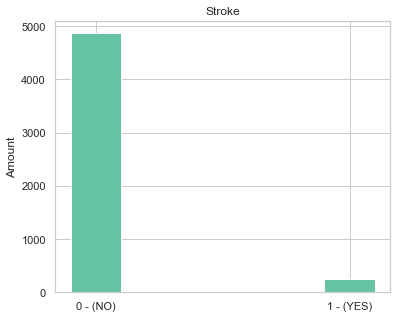

Stroke 
 0    4861
1     249
Name: stroke, dtype: int64
Imbalance ratio: 4.87%


In [6]:
#distribution of 'outcome_damage_inc'
A= dfData['stroke'].value_counts()
width = 6
height = 5
plt.figure(figsize=(width, height))
plt.bar(['0 - (NO)', '1 - (YES)'], A, width=0.2)
plt.ylabel("Amount")
plt.title('Stroke')
plt.show()
print("Stroke","\n", A)
print(f"Imbalance ratio: {int(A[1]/(A[1]+A[0])*10000)/100}%")


This is a very imbalanced data set!

### Distribution of non Categorical features
We fisrt look to the overall distribution of all non categorical features.

In [7]:
def distPlot(dataSet, features, hue=None):
    """
    Displays density distirbution of the variable, 
    distributions per category (hue),
    box plot per category
    and qq-plot in comparison with normal distribution
    """
    
    for feat in features:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

        sns.kdeplot(data=dataSet, x=feat, fill=True, ax=ax1)
        ax1.set_title(f'Density of {feat}')

        sns.kdeplot(data=dataSet, x=feat, hue=hue, fill=True, ax=ax2)
        ax2.set_title(f'Separate densities of {feat} vs stroke')

        sns.boxplot(x=hue, y=feat, data=dataSet, ax=ax3)
        ax3.set_title(f'Boxplots of {feat} vs stroke')

        qqplot(dataSet[feat][~dataSet[feat].isnull()], line='s', ax=ax4);
        ax4.set_title(f'QQ-plot {feat} vs Normal distribution')

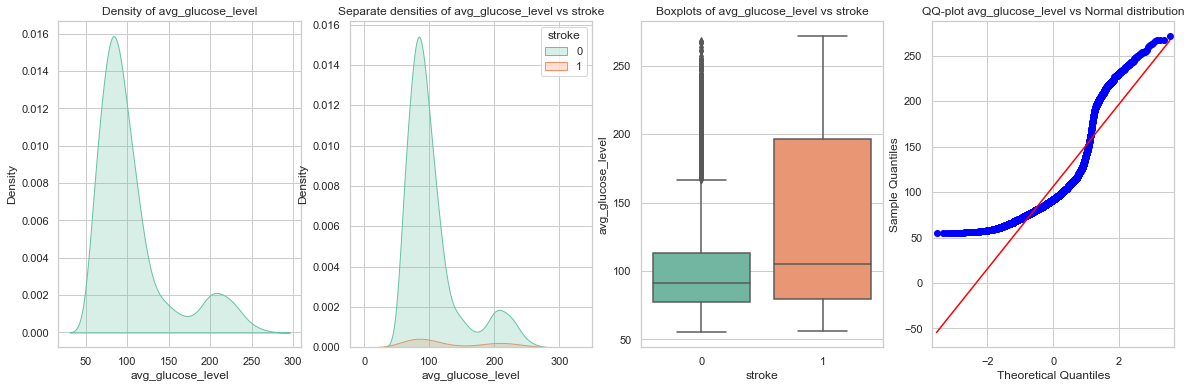

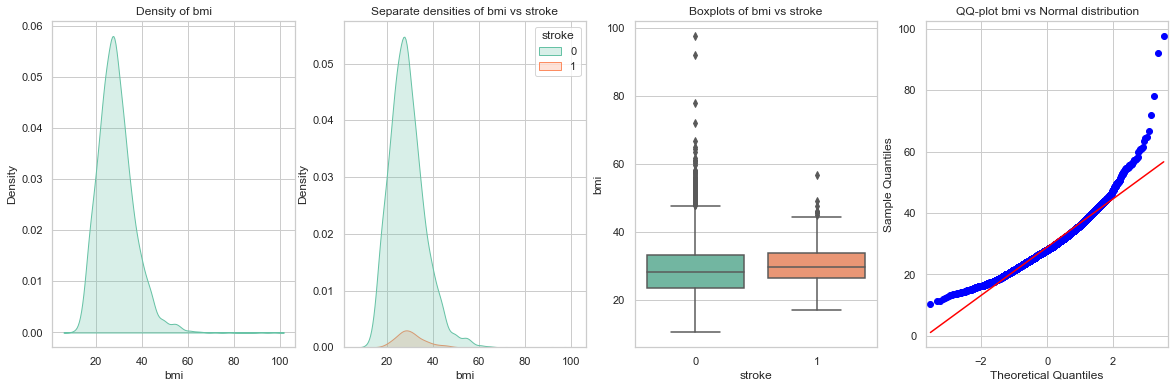

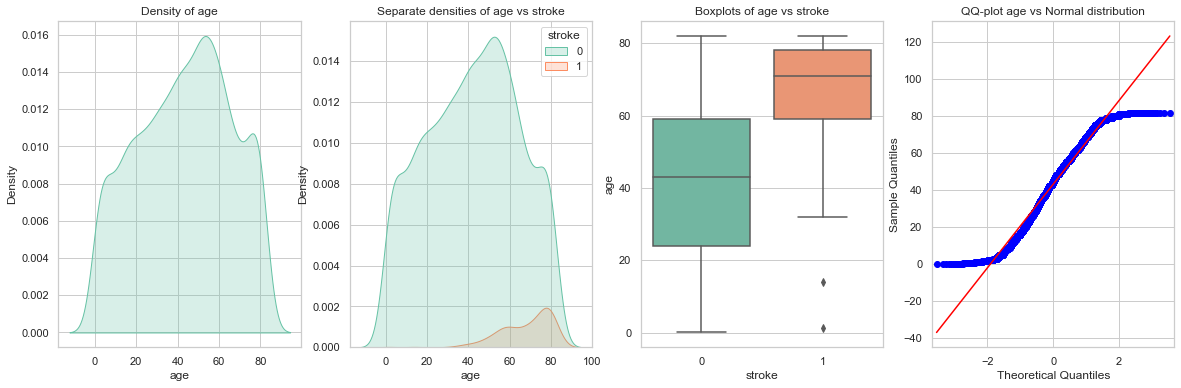

In [8]:
distPlot(dataSet=dfData, features=nonCatFeat, hue="stroke")

**Insights from distributions:**

Insights from Average glocuse level:

* It is a bimodal distristibution with the global mode around 80, and a local mode around 200.
* The bimodality is also present among data poitns of people with stroke and people with no strokes. 
* Obvoulsly it is not normally distributed, and it has a sort of long tail to the right (maybe plot with log transform?).
* The median Average glocuse level of people with a stroke is higher than the median for people with no stroke.
* The interquartile range is way bigger among the data points of people with a stroke.


Insights from bmi (body mass index):

* It is a unimodal distristibution with the global mode around 30.
* The unimodality is also present among data poitns of people with stroke and people with no strokes. 
* It has a long long tail to the right, but with very small densities. So there are a some outliers. 
* Except for the long tail, the qq plot shows some resemblance to the normal distribution.
* The median, mode, and the distribution in general, seem to remain almost the same among peole with and whotout stroke.

Insights from age:

* It is a bymodal distristibution with the global mode around 50, and a local mode around 75.
* We see that the distribution for people qith stroke has the mode around 75 as well.
* Except for the two tails, the qq plot shows some resemblance to the normal distribution.
* The boxplots show that the age is an important factor for strokes. Pleople with strokes are older.



Let's have a look at those long tails. Let's plot histgrams for "bmi" and "avg_glucose_level" using using a log transform, and let's compare the log transformations to the normal distribution.

In [9]:
def histLogDistPlot(dataSet, features, hue=None, binwidth=0.05):
    """
    Function to plot histograms and distributions
    """
    
    for feat in features:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        sns.histplot(x=feat, hue=hue, data=dataSet, palette ={0: "blue", 1: "red"}, 
                     log_scale=2, kde=True, binwidth=binwidth, ax =ax1)
        ax1.set_title(f"Histogram of {feat} in log2 scale")

        log2Data = np.log2(dataSet[feat][~dataSet[feat].isnull()])
        qqplot(log2Data, line='s', ax=ax2);
        ax2.set_title(f'QQ-plot log({feat}) vs Normal distribution')

        sns.boxplot(x=hue, y=log2Data, data=dataSet, ax=ax3)
        ax3.set_title(f'Boxplots of log({feat}) vs stroke')

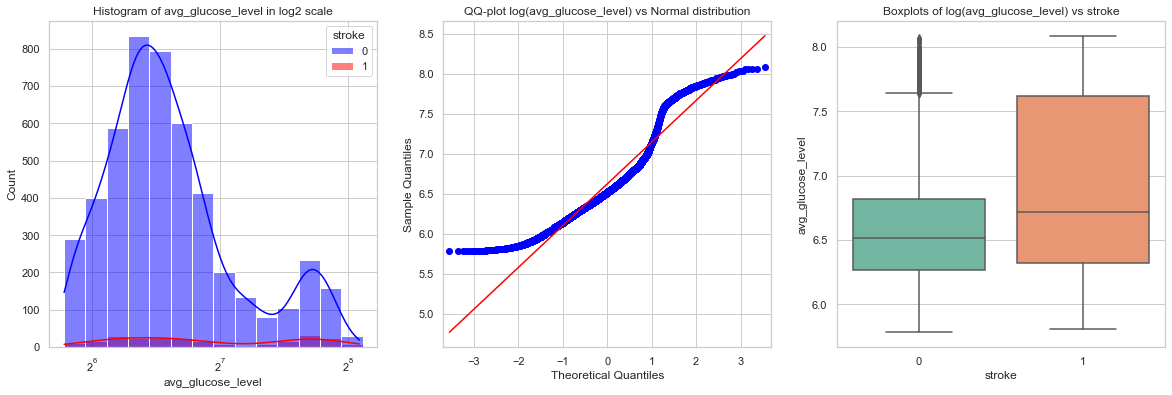

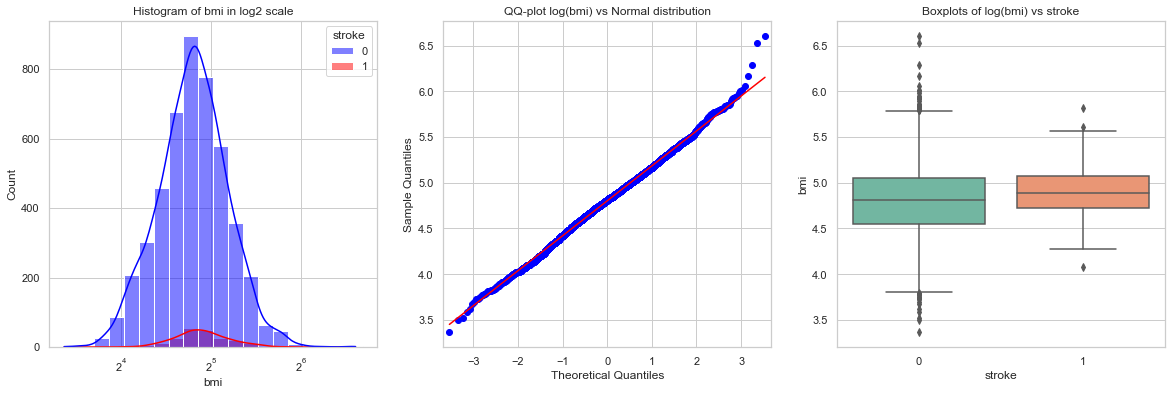

In [10]:
histLogDistPlot(dataSet=dfData, features=["avg_glucose_level", "bmi"], hue="stroke")

The log transform take us very close to a normal distribution for "bmi", while for "avg_glucose_level" we still observe the bimodality, but now in a more clear and distinctive fashion. 

Let's us include these transformations to the data frame, so that we can use them later. 

In [11]:
for feat in ["avg_glucose_level", "bmi"]:
    dfData[f"log2({feat})"] = np.log2(dfData[feat])

In [12]:
#Adding log tranformed columns to nonCatFeat
nonCatFeat = nonCatFeat + [f"log2({feat})" for feat in ["avg_glucose_level", "bmi"]]
nonCatFeat

['avg_glucose_level', 'bmi', 'age', 'log2(avg_glucose_level)', 'log2(bmi)']

### Categorical features

In [13]:
def histProbs(dataSet, features, hue=None, shrink=.5):
    """
    Displays histograms for categorical features,
    provide analysis their distribution when grouped by hue.
    """
    
    for feat in features:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

        sns.histplot(x=feat, hue=hue, multiple="dodge", data=dataSet, shrink=.5, palette ={0: "blue", 1: "red"}, ax=ax1)
        ax1.set_title(f'{feat} distribution')

        values = dataSet[feat].unique()
        probs = []

        for val in values:
            s1 = (dataSet[feat] == val)
            s2 = (dataSet[feat] == val) & (dataSet[hue] == 1)
            probs.append(round(s2.sum()/s1.sum()*100, 2))

        plt.bar(values, probs)
        ax2.set_title(f'Proportion of strokes w.r.t. different values of {feat}')
    

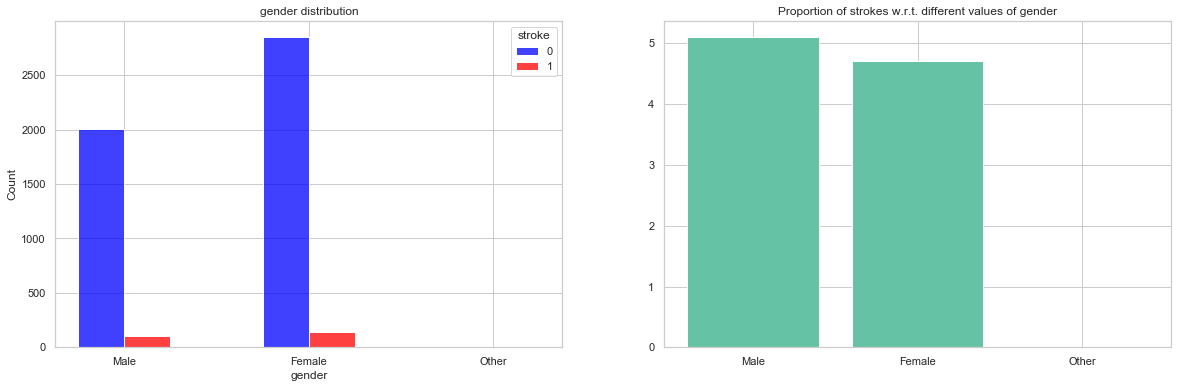

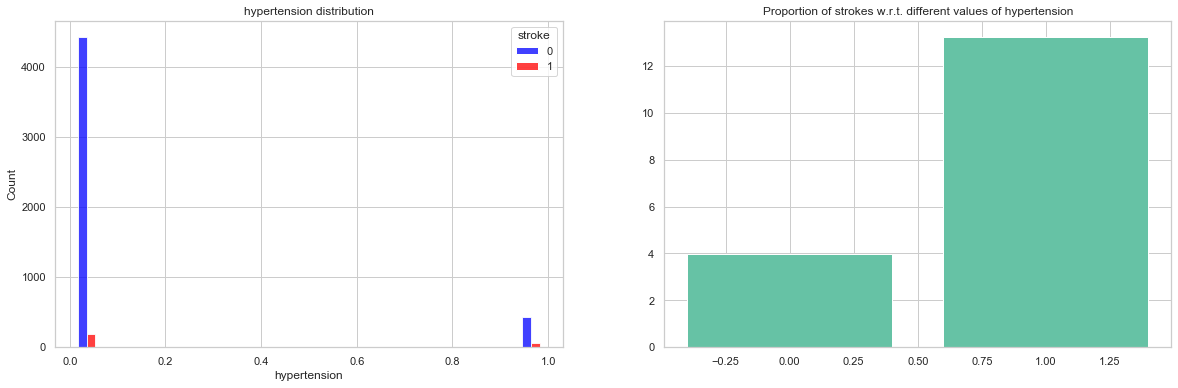

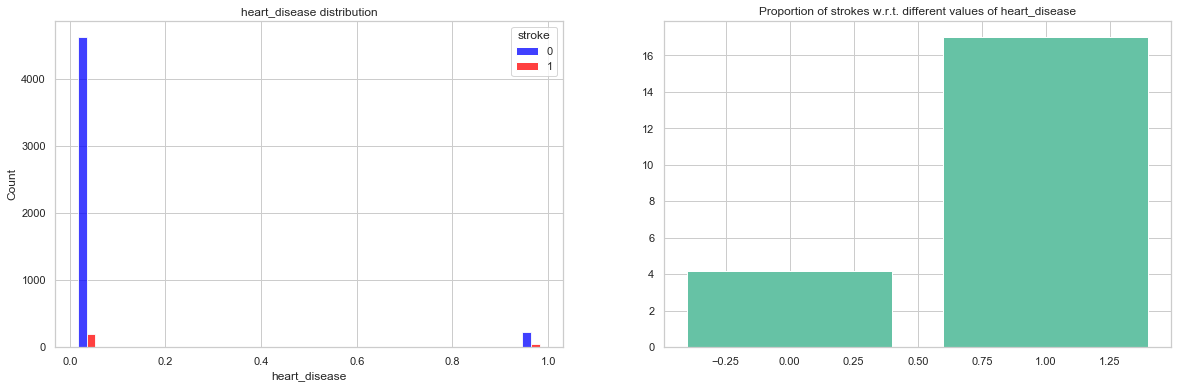

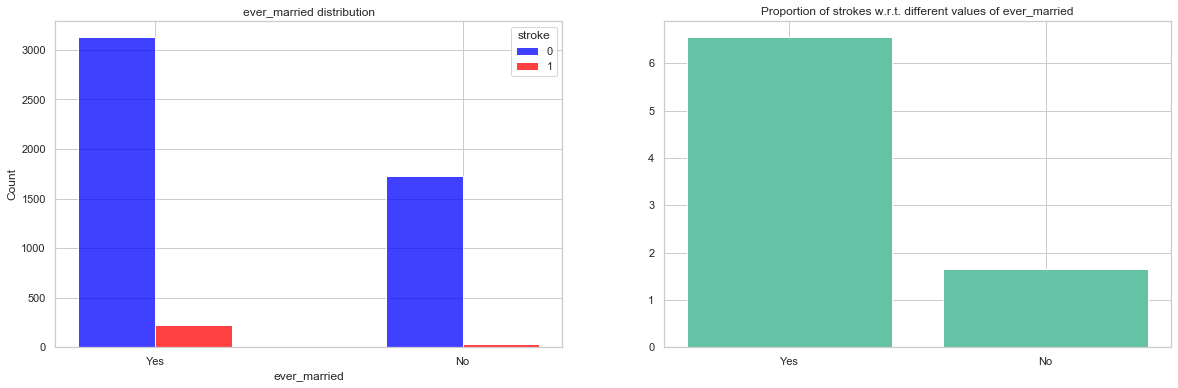

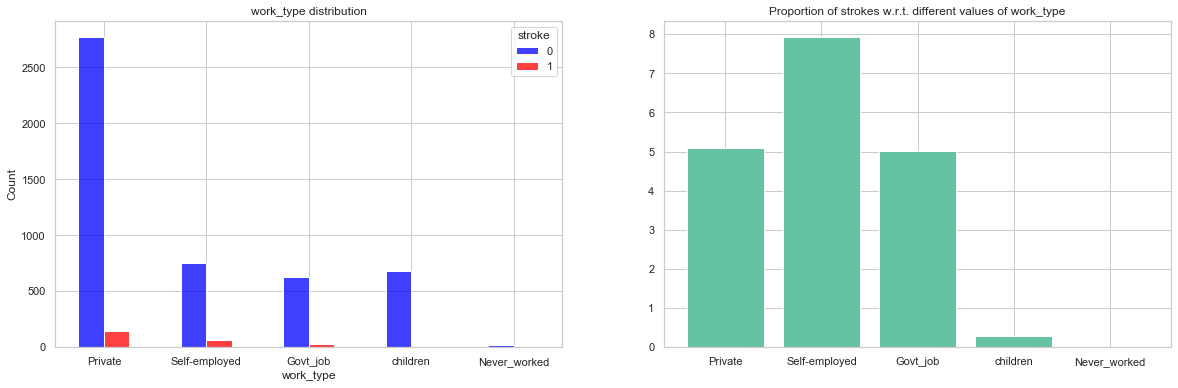

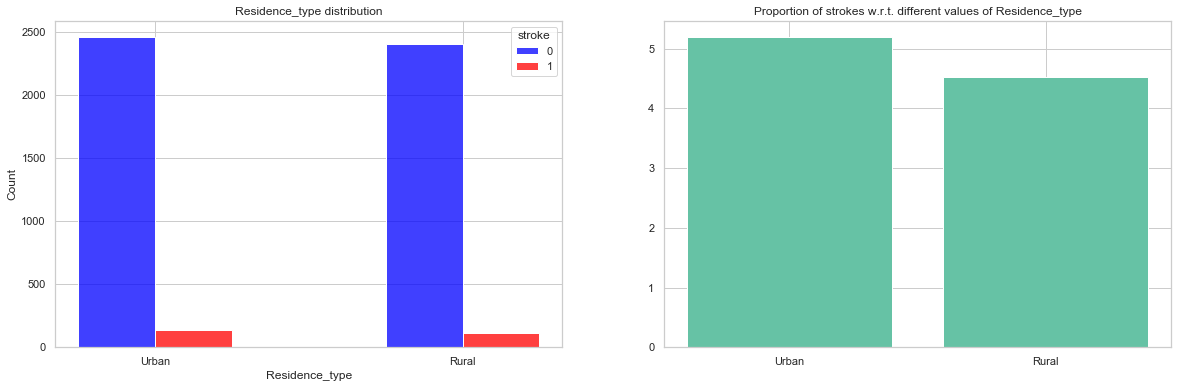

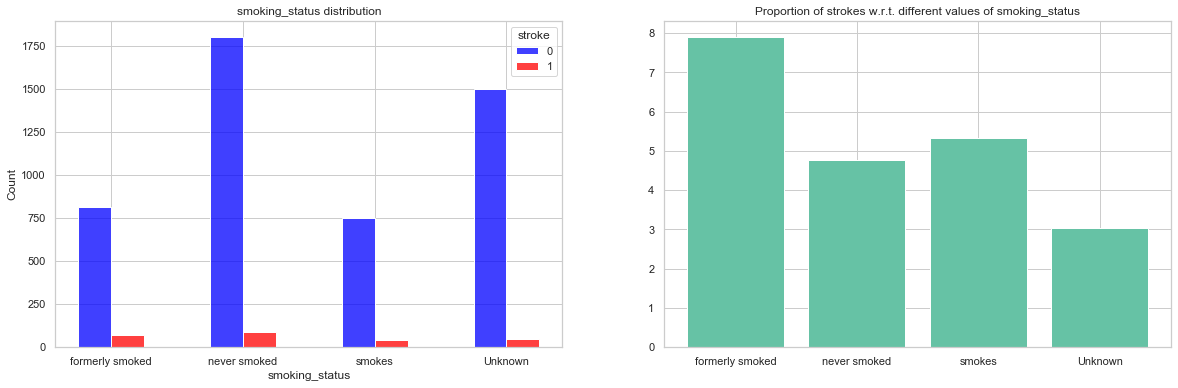

In [14]:
histProbs(dataSet=dfData, features=CatFeat, hue="stroke")

Insights:
* In absolute numbers more women had an stroke, but this is due to the fact that women are majority. As a matter of fact, there is higher probability of having a stroke of you are a man (~5.1% vs ~4.5%). 

* In absolute numbers people with no hypertension had more strokes, but this is due to the fact that most people have no hypertension. As a matter of fact, there is a way higher probability of having a stroke of you hypertense (~12.5% vs ~4%).

* In absolute numbers people with no heart disease had more strokes, but this is due to the fact that most people have no heart disease. As a matter of fact, there is a way higher probability of having a stroke of you have a heart disease (~16.5% vs ~4%).

* In absolute numbers people with are married had more strokes. Also, if you are married the probability of having a stroke is higher (~6.5% vs ~1.8%).

* In absolute numbers people working in the private sector had more strokes, but this is due to the fact that most people work in the private sector. As a matter of fact, you have the highest probability of a stroke working as self-employed (~8%). People that never worked, have almost zero probability of stroke.

* There is a slightly higher probability of havig a stroke if you live in a urban are (~5.2% vs ~4.5%).

* Although in all smokers category there seems to be a comparable number of strokes, former smokers have the highest probability (8%). People with a unknown status have the lowest probability (3%).

We also note that there is one person whose gender is "other".

In [15]:
dfData[dfData["gender"] == "Other"]

id gender   age  hypertension  heart_disease ever_married work_type  \
3116  56156  Other  26.0             0              0           No   Private   

     Residence_type  avg_glucose_level   bmi   smoking_status  stroke  \
3116          Rural             143.33  22.4  formerly smoked       0   

      log2(avg_glucose_level)  log2(bmi)  
3116                 7.163197   4.485427

 ## 1.3 Feature engineering and looking for potential relations <a class="anchor" id="SubSection_1_3"></a>

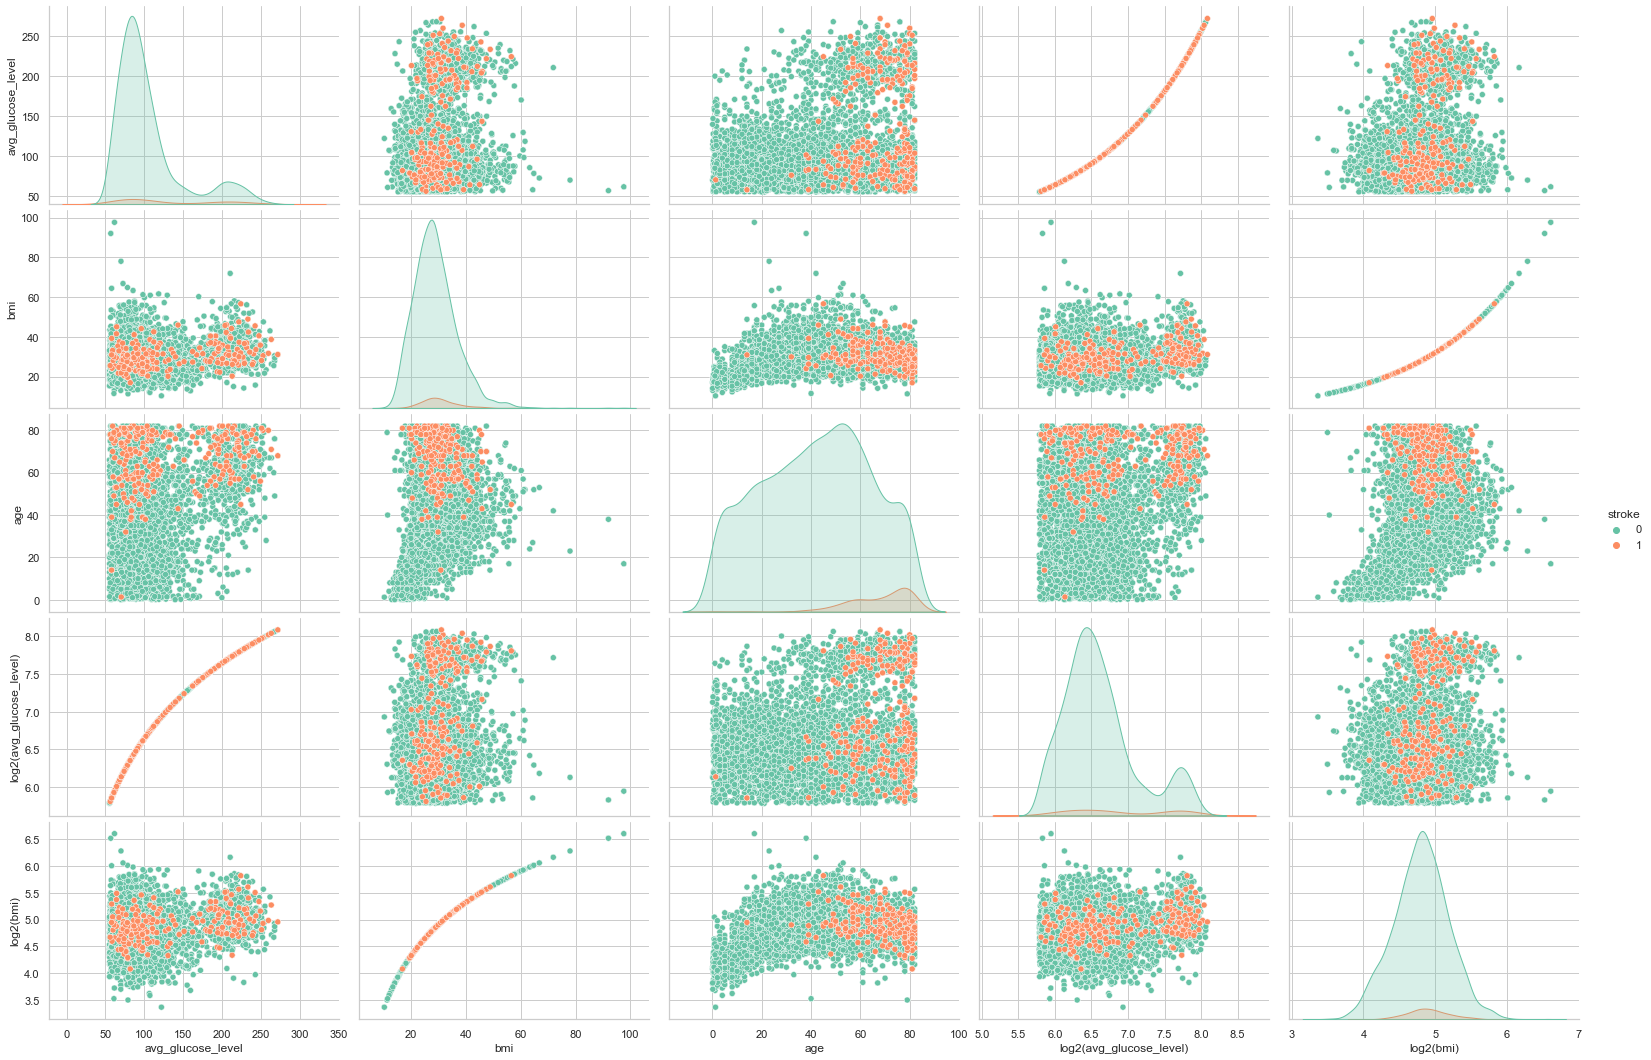

In [16]:
g = sns.pairplot(data=dfData.sort_values("stroke"), 
                 vars=nonCatFeat, 
                 hue = 'stroke', aspect=1.5, height=3, dropna=True)
g.map_offdiag(sns.scatterplot, sizes=(200,40))
plt.show();

We notice that the points representing strokes patitiens can (most of the time) be well-localized. Maybe tree based mehtods work well here.

Let us now combine one categorical variable with a non-categorial and look at the resulting boxplots.

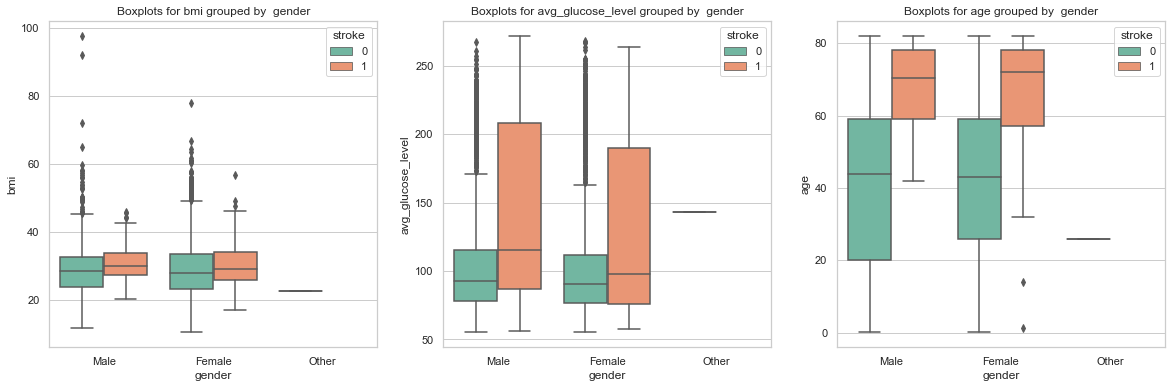

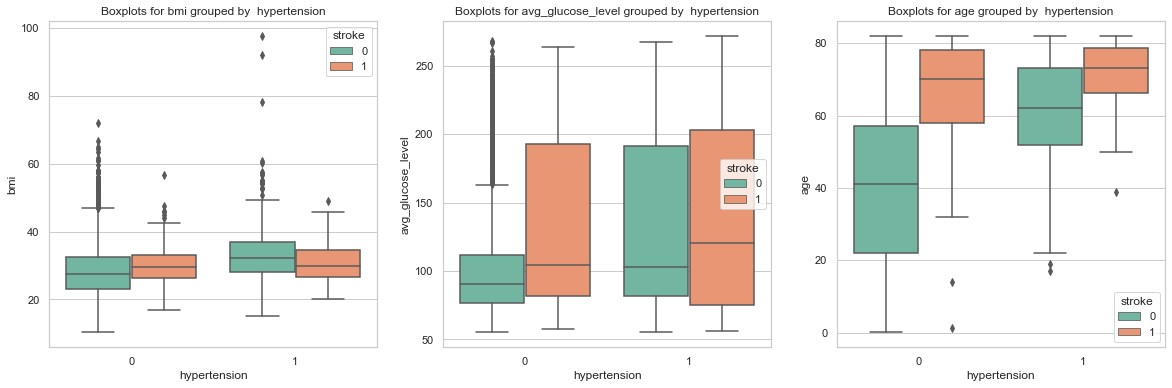

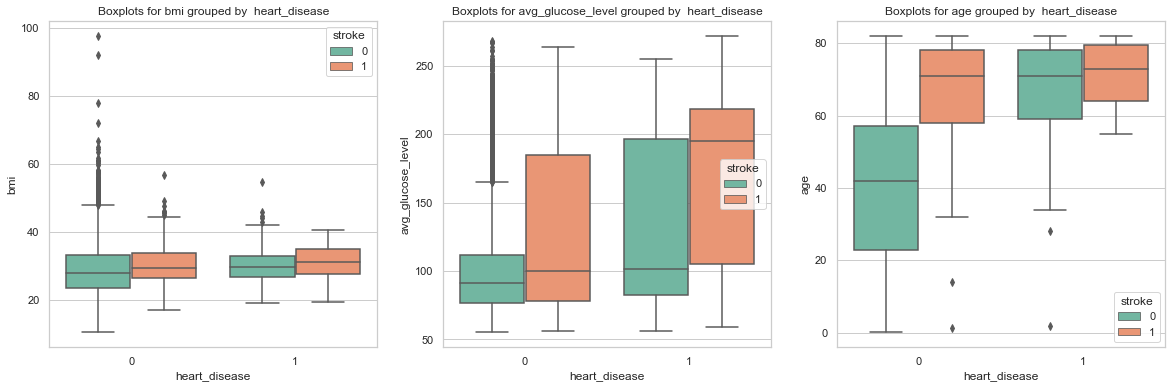

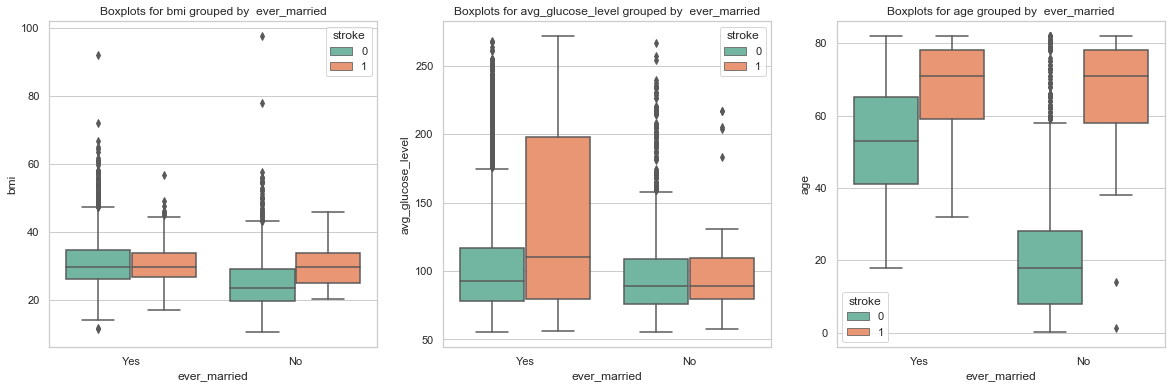

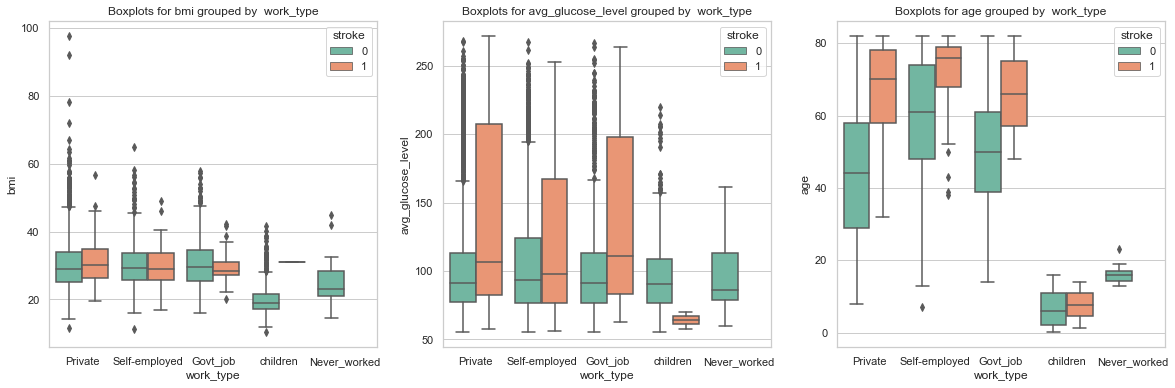

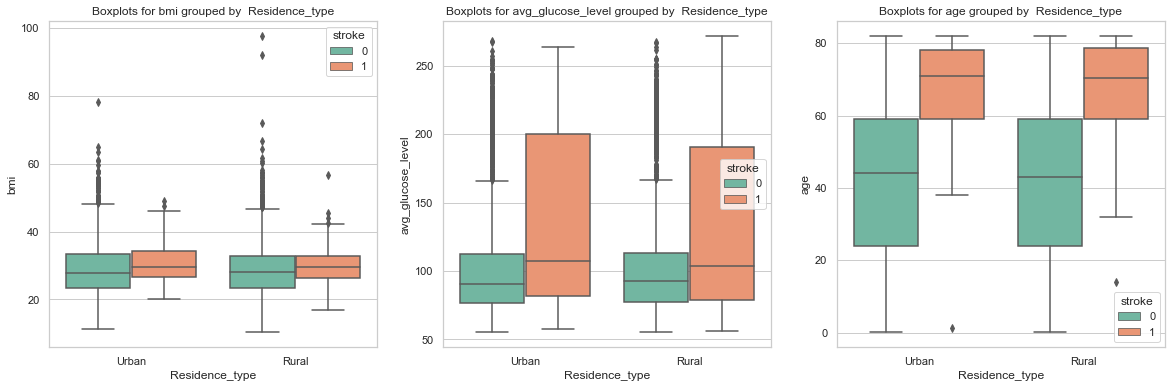

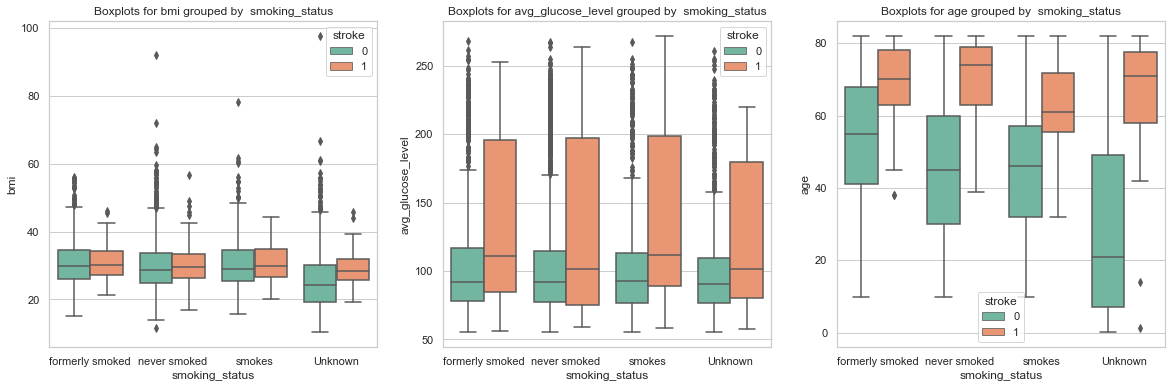

In [17]:
for feat in CatFeat:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    sns.boxplot(x=feat, y="bmi", hue="stroke", data=dfData, ax=ax1)
    ax1.set_title(f'Boxplots for bmi grouped by  {feat}')
    
    sns.boxplot(x=feat, y="avg_glucose_level", hue="stroke", data=dfData, ax=ax2)
    ax2.set_title(f'Boxplots for avg_glucose_level grouped by  {feat}')
    
    sns.boxplot(x=feat, y="age", hue="stroke", data=dfData, ax=ax3)
    ax3.set_title(f'Boxplots for age grouped by  {feat}')


Summary of insights:
* For the  bmi there are no many surpirses, the distribution of the values remains quasi-normal in all groups.
* For avg_glucose_level we see that for stroke patienes, the median among those with heart dsisease is way higher than that of patienets whitou heart disease.
* The median age of stroke patienes that are also smokers is lower that of other stroke patients.


### Dummies

Before we proceed to create new engineered variables, let us take care of the dummies first. To be carefull with adding non informative correlations, we shall drop the first dommy per category, this isour reference class,

In [18]:
dfData

id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  log2(avg_glucose_level)  log2(bmi)  
0          1                 7.837249   5.193772  
1          1                 7.659711        NaN  
2          1                 6.726831   5.022368  
3          1                 7.419792   5.104337  
4          1                 7.443938   4.584963  
...      ...                      ...        ...  
5105       0                 6.388017        NaN  
5106       0                 6.968091   5.321928  
5107       0                 6.374866   4.935460  
5108       0                 7.377558   4.678072  
5109       0                 6.414136   4.711495  

[5110 rows x 14 columns]

In [19]:
dummiesKeepFirst = []
dummiesNOFirst = ['ever_married', 'Residence_type', 'gender',  'work_type', 'smoking_status']


In [20]:
dfData = pd.get_dummies(dfData, columns = dummiesNOFirst, drop_first = True, dtype=int)
dfData

id   age  hypertension  heart_disease  avg_glucose_level   bmi  \
0      9046  67.0             0              1             228.69  36.6   
1     51676  61.0             0              0             202.21   NaN   
2     31112  80.0             0              1             105.92  32.5   
3     60182  49.0             0              0             171.23  34.4   
4      1665  79.0             1              0             174.12  24.0   
...     ...   ...           ...            ...                ...   ...   
5105  18234  80.0             1              0              83.75   NaN   
5106  44873  81.0             0              0             125.20  40.0   
5107  19723  35.0             0              0              82.99  30.6   
5108  37544  51.0             0              0             166.29  25.6   
5109  44679  44.0             0              0              85.28  26.2   

      stroke  log2(avg_glucose_level)  log2(bmi)  ever_married_Yes  \
0          1                 7.837249   5.193772                 1   
1          1                 7.659711        NaN                 1   
2          1                 6.726831   5.022368                 1   
3          1                 7.419792   5.104337                 1   
4          1                 7.443938   4.584963                 1   
...      ...                      ...        ...               ...   
5105       0                 6.388017        NaN                 1   
5106       0                 6.968091   5.321928                 1   
5107       0                 6.374866   4.935460                 1   
5108       0                 7.377558   4.678072                 1   
5109       0                 6.414136   4.711495                 1   

      Residence_type_Urban  gender_Male  gender_Other  work_type_Never_worked  \
0                        1            1             0                       0   
1                        0            0             0                       0   
2                        0            1             0                       0   
3                        1            0             0                       0   
4                        0            0             0                       0   
...                    ...          ...           ...                     ...   
5105                     1            0             0                       0   
5106                     1            0             0                       0   
5107                     0            0             0                       0   
5108                     0            1             0                       0   
5109                     1            0             0                       0   

      work_type_Private  work_type_Self-employed  work_type_children  \
0                     1                        0                   0   
1                     0                        1                   0   
2                     1                        0                   0   
3                     1                        0                   0   
4                     0                        1                   0   
...                 ...                      ...                 ...   
5105                  1                        0                   0   
5106                  0                        1                   0   
5107                  0                        1                   0   
5108                  1                        0                   0   
5109                  0                        0                   0   

      smoking_status_formerly smoked  smoking_status_never smoked  \
0                                  1                            0   
1                                  0                            1   
2                                  0                            1   
3                                  0                            0   
4                                  0                            1   
...            

In [21]:
#Updating CatFeat
columns = list(dfData.columns)
CatFeat = [feat for feat in columns if feat not in nonCatFeat+['stroke', 'id']]
len(CatFeat)+len(nonCatFeat)

18

### New features

The conclusions drawn from the previous visualizations suggest considering the following new features which might be beneficial for our analysis:

Among continuous features
* log2(bmi) * age (higher bmi and age mihgt indicitate higher probability of stroke)
* log2(avg_glucose_level) / bmi
* log2(avg_glucose_level) * age

Between continuous and categorical (in each case we replace for eah categorical variable 0 by -1 and keep 1 as 1):

* age * heart_disease
* age * hypertension
* age * ever_married_Yes
* age * Residence_type_Urban
* age * smoking_status_smokes

Among categorical
* All combinations of two products among ["hypertension", "ever_married_Yes", "heart_disease", "work_type_Self-employed", "smoking_status_formerly smoked"]

In [22]:
#Among continuous features
dfData["log2(bmi)_times_age"] = dfData["log2(bmi)"] * dfData["age"]
dfData["log2(avg_glucose_level)_per_bmiUnit"] = dfData["log2(avg_glucose_level)"] / dfData["bmi"]
dfData["log2(avg_glucose_level)_times_age"] = dfData["log2(avg_glucose_level)"] * dfData["age"]

#adding new variables to nonCatFeat
nonCatFeat += ["log2(bmi)_times_age", "log2(avg_glucose_level)_per_bmiUnit", "log2(avg_glucose_level)_times_age"]

dfData

id   age  hypertension  heart_disease  avg_glucose_level   bmi  \
0      9046  67.0             0              1             228.69  36.6   
1     51676  61.0             0              0             202.21   NaN   
2     31112  80.0             0              1             105.92  32.5   
3     60182  49.0             0              0             171.23  34.4   
4      1665  79.0             1              0             174.12  24.0   
...     ...   ...           ...            ...                ...   ...   
5105  18234  80.0             1              0              83.75   NaN   
5106  44873  81.0             0              0             125.20  40.0   
5107  19723  35.0             0              0              82.99  30.6   
5108  37544  51.0             0              0             166.29  25.6   
5109  44679  44.0             0              0              85.28  26.2   

      stroke  log2(avg_glucose_level)  log2(bmi)  ever_married_Yes  ...  \
0          1                 7.837249   5.193772                 1  ...   
1          1                 7.659711        NaN                 1  ...   
2          1                 6.726831   5.022368                 1  ...   
3          1                 7.419792   5.104337                 1  ...   
4          1                 7.443938   4.584963                 1  ...   
...      ...                      ...        ...               ...  ...   
5105       0                 6.388017        NaN                 1  ...   
5106       0                 6.968091   5.321928                 1  ...   
5107       0                 6.374866   4.935460                 1  ...   
5108       0                 7.377558   4.678072                 1  ...   
5109       0                 6.414136   4.711495                 1  ...   

      work_type_Never_worked  work_type_Private  work_type_Self-employed  \
0                          0                  1                        0   
1                          0                  0                        1   
2                          0                  1                        0   
3                          0                  1                        0   
4                          0                  0                        1   
...                      ...                ...                      ...   
5105                       0                  1                        0   
5106                       0                  0                        1   
5107                       0                  0                        1   
5108                       0                  1                        0   
5109                       0                  0                        0   

      work_type_children  smoking_status_formerly smoked  \
0                      0                               1   
1                      0                               0   
2                      0                               0   
3                      0                               0   
4                      0                               0   
...                  ...                             ...   
5105                   0                               0   
5106                   0                               0   
5107                   0                               0   
5108                   0                               1   
5109                   0                               0   

      smoking_status_never smoked  smoking_status_smokes  log2(bmi)_times_age  \
0                               0                      0           347.982707   
1                               1                      0                  NaN   
2                               1                      0           401.789425   
3                               0                      1           250.112496   
4                               1                      0           362.212038   
...                           ...                    ...                  ...   
5105  

In [23]:
print(len(CatFeat)+len(nonCatFeat))

21


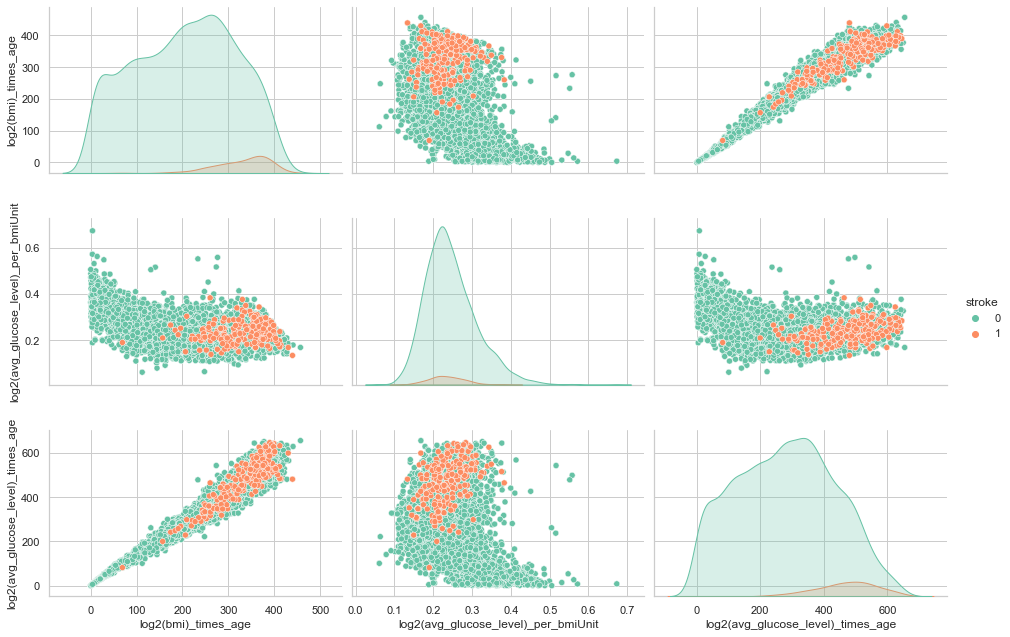

In [24]:
g = sns.pairplot(data=dfData.sort_values("stroke"), 
                 vars=["log2(bmi)_times_age", "log2(avg_glucose_level)_per_bmiUnit", "log2(avg_glucose_level)_times_age"], 
                 hue = 'stroke', aspect=1.5, height=3, dropna=True)
g.map_offdiag(sns.scatterplot, sizes=(200,40))
plt.show();

We see that the data point with stroke are better localized.

In [25]:
#Between continuous and categorical
lst = ["hypertension", "ever_married_Yes", "heart_disease", "Residence_type_Urban", "smoking_status_smokes"]
for feat in lst:
    dfData[f"{feat}_times_age"] = (2*dfData[feat]-1) * dfData["age"]
    
#Adding new features to nonCatFeat
new_lst = [f"{feat}_times_age" for feat in lst]
nonCatFeat += new_lst

print(len(CatFeat)+len(nonCatFeat))
dfData


26


id   age  hypertension  heart_disease  avg_glucose_level   bmi  \
0      9046  67.0             0              1             228.69  36.6   
1     51676  61.0             0              0             202.21   NaN   
2     31112  80.0             0              1             105.92  32.5   
3     60182  49.0             0              0             171.23  34.4   
4      1665  79.0             1              0             174.12  24.0   
...     ...   ...           ...            ...                ...   ...   
5105  18234  80.0             1              0              83.75   NaN   
5106  44873  81.0             0              0             125.20  40.0   
5107  19723  35.0             0              0              82.99  30.6   
5108  37544  51.0             0              0             166.29  25.6   
5109  44679  44.0             0              0              85.28  26.2   

      stroke  log2(avg_glucose_level)  log2(bmi)  ever_married_Yes  ...  \
0          1                 7.837249   5.193772                 1  ...   
1          1                 7.659711        NaN                 1  ...   
2          1                 6.726831   5.022368                 1  ...   
3          1                 7.419792   5.104337                 1  ...   
4          1                 7.443938   4.584963                 1  ...   
...      ...                      ...        ...               ...  ...   
5105       0                 6.388017        NaN                 1  ...   
5106       0                 6.968091   5.321928                 1  ...   
5107       0                 6.374866   4.935460                 1  ...   
5108       0                 7.377558   4.678072                 1  ...   
5109       0                 6.414136   4.711495                 1  ...   

      smoking_status_never smoked  smoking_status_smokes  log2(bmi)_times_age  \
0                               0                      0           347.982707   
1                               1                      0                  NaN   
2                               1                      0           401.789425   
3                               0                      1           250.112496   
4                               1                      0           362.212038   
...                           ...                    ...                  ...   
5105                            1                      0                  NaN   
5106                            1                      0           431.076176   
5107                            1                      0           172.741091   
5108                            0                      0           238.581667   
5109                            0                      0           207.305776   

      log2(avg_glucose_level)_per_bmiUnit  log2(avg_glucose_level)_times_age  \
0                                0.214132                         525.095715   
1                                     NaN                         467.242343   
2                                0.206979                         538.146497   
3                                0.215692                         363.569792   
4                                0.310164                         588.071111   
...                                   ...                                ...   
5105                                  NaN                         511.041383   
5106                             0.174202                         564.415351   
5107                             0.208329                         223.120296   
5108                             0.288186                         376.255438   
5109                             0.244814                         282.221963   

      hypertension_times_age  ever_married_Yes_times_age  \
0                      -67.0                        67.0   
1                      -61.0                        61.0   
2                      -80.0                        80.0   
3                      -49.0     

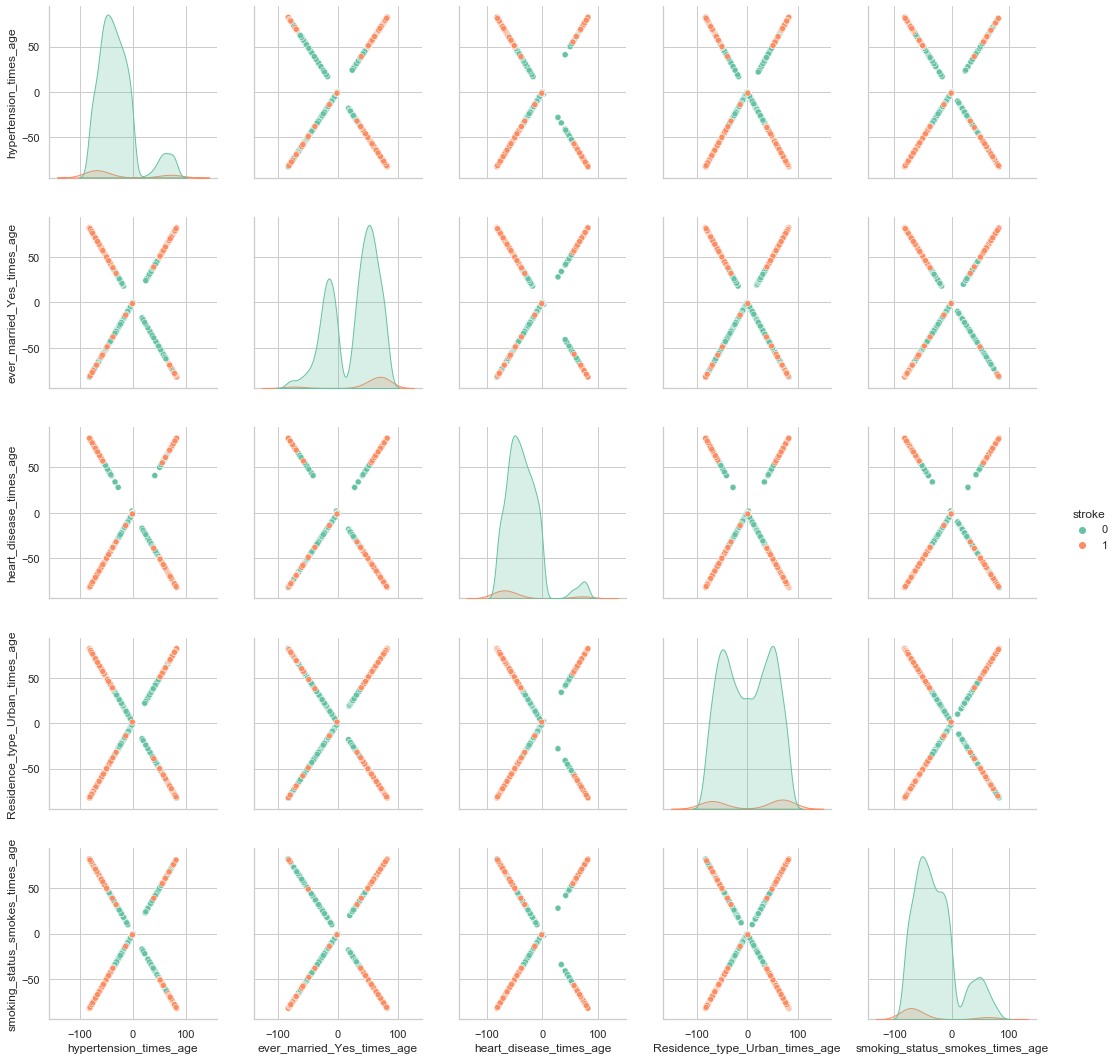

In [26]:
new_lst = [f"{feat}_times_age" for feat in lst]
g = sns.pairplot(data=dfData.sort_values("stroke"), 
                 vars=new_lst, 
                 hue = 'stroke', aspect=1, height=3, dropna=True)
g.map_offdiag(sns.scatterplot, sizes=(200,40))
plt.show();

In [27]:
import itertools 

newCatLst=["hypertension", "ever_married_Yes", "heart_disease", "work_type_Self-employed", "smoking_status_formerly smoked"]
pairs = list(itertools.combinations(newCatLst, 2))

for feat1, feat2 in pairs:
    dfData[f"{feat1}_and_{feat2}"] = dfData[feat1] * dfData[feat2]
    
newPairs = [f"{feat1}_and_{feat2}" for feat1, feat2 in pairs]
CatFeat += newPairs

print(len(CatFeat)+len(nonCatFeat))
dfData


36


id   age  hypertension  heart_disease  avg_glucose_level   bmi  \
0      9046  67.0             0              1             228.69  36.6   
1     51676  61.0             0              0             202.21   NaN   
2     31112  80.0             0              1             105.92  32.5   
3     60182  49.0             0              0             171.23  34.4   
4      1665  79.0             1              0             174.12  24.0   
...     ...   ...           ...            ...                ...   ...   
5105  18234  80.0             1              0              83.75   NaN   
5106  44873  81.0             0              0             125.20  40.0   
5107  19723  35.0             0              0              82.99  30.6   
5108  37544  51.0             0              0             166.29  25.6   
5109  44679  44.0             0              0              85.28  26.2   

      stroke  log2(avg_glucose_level)  log2(bmi)  ever_married_Yes  ...  \
0          1                 7.837249   5.193772                 1  ...   
1          1                 7.659711        NaN                 1  ...   
2          1                 6.726831   5.022368                 1  ...   
3          1                 7.419792   5.104337                 1  ...   
4          1                 7.443938   4.584963                 1  ...   
...      ...                      ...        ...               ...  ...   
5105       0                 6.388017        NaN                 1  ...   
5106       0                 6.968091   5.321928                 1  ...   
5107       0                 6.374866   4.935460                 1  ...   
5108       0                 7.377558   4.678072                 1  ...   
5109       0                 6.414136   4.711495                 1  ...   

      hypertension_and_ever_married_Yes  hypertension_and_heart_disease  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     1                               0   
...                                 ...                             ...   
5105                                  1                               0   
5106                                  0                               0   
5107                                  0                               0   
5108                                  0                               0   
5109                                  0                               0   

      hypertension_and_work_type_Self-employed  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            1   
...                                        ...   
5105                                         0   
5106                                         0   
5107                                         0   
5108                                         0   
5109                                         0   

      hypertension_and_smoking_status_formerly smoked  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
...                                               ...   
5105                                                0   
5106                                                0   
5107                                                0   
5108                                                0   
5109                                                0   

      ever_married_Y

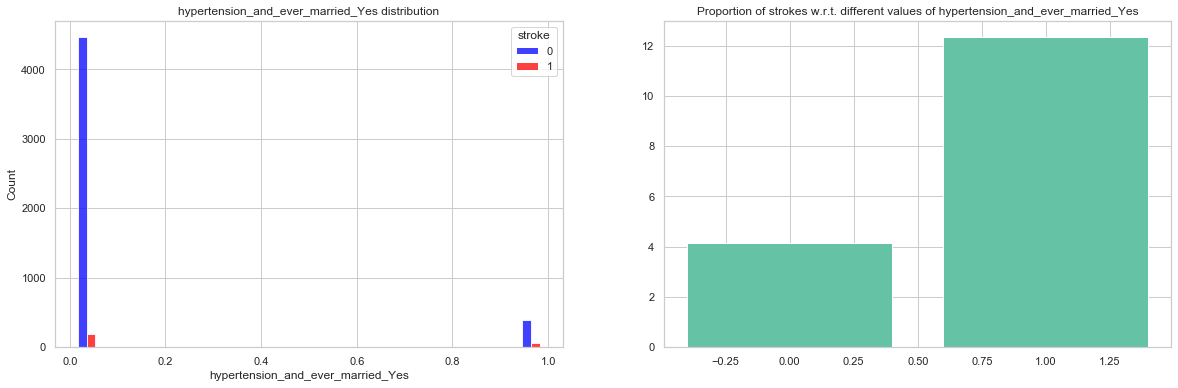

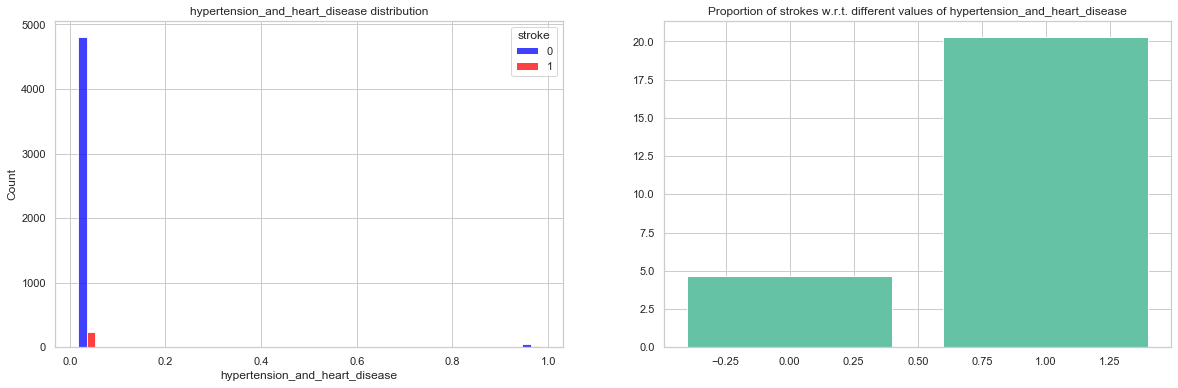

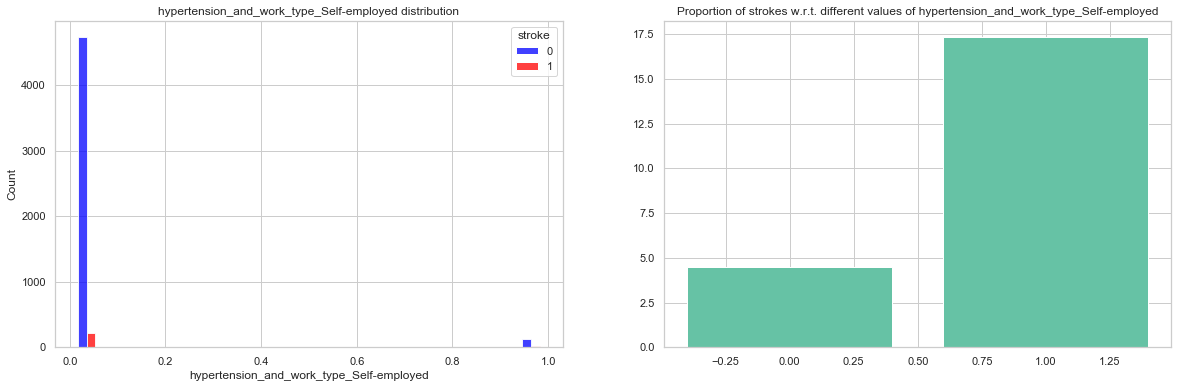

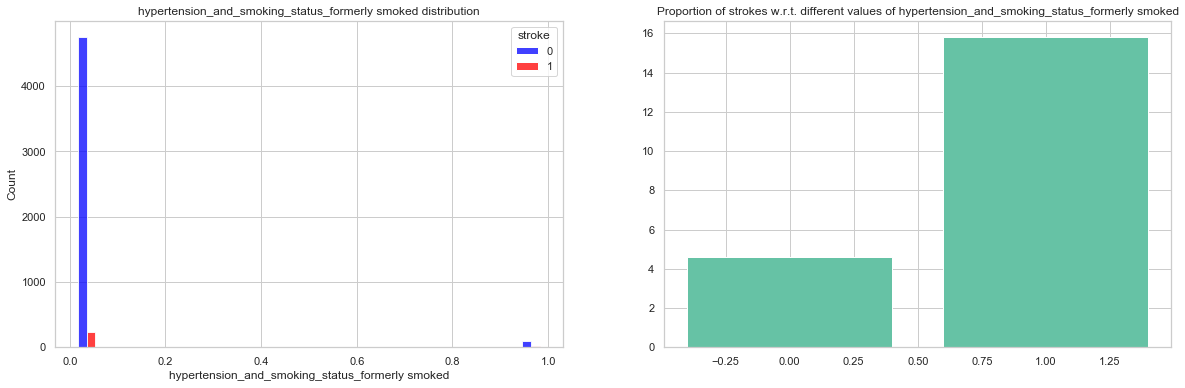

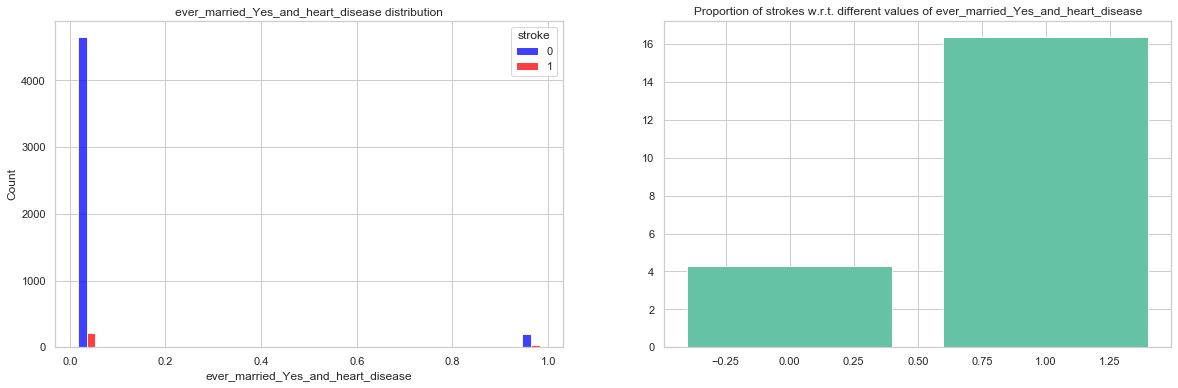

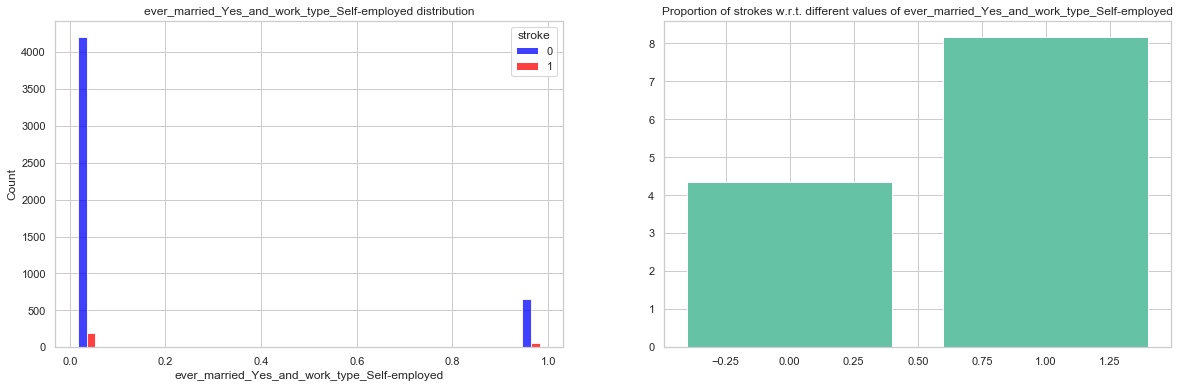

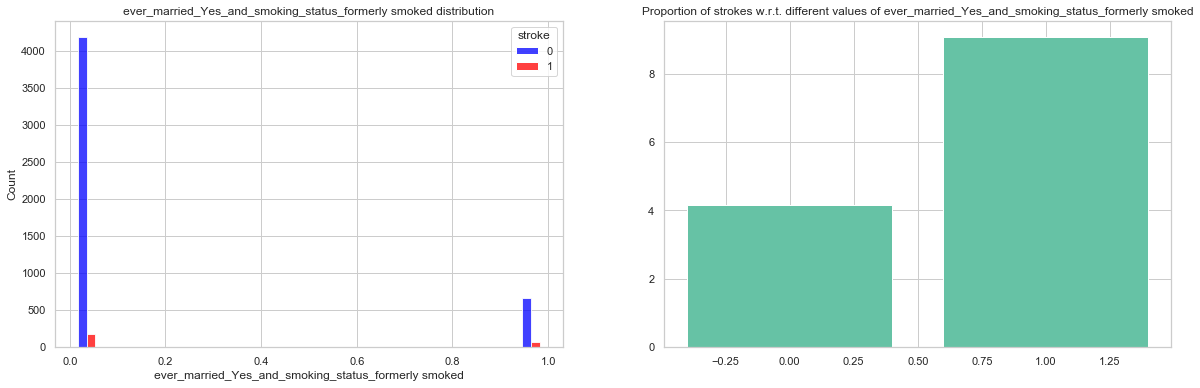

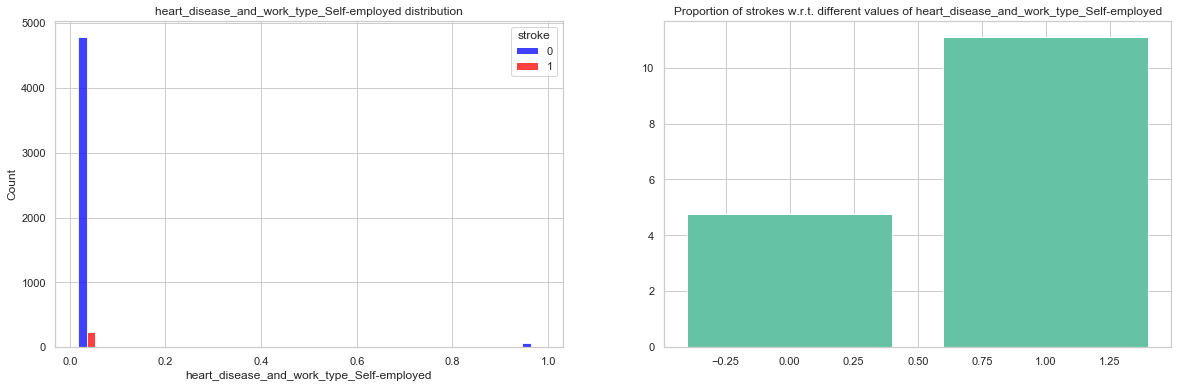

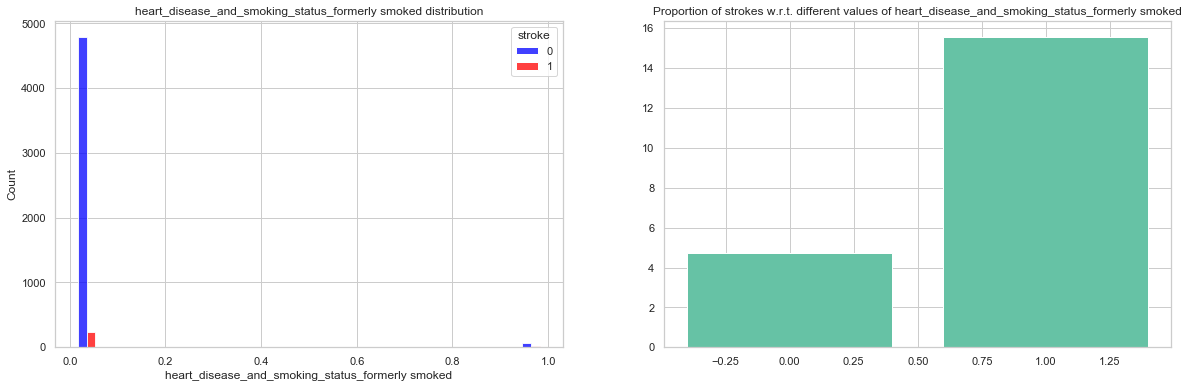

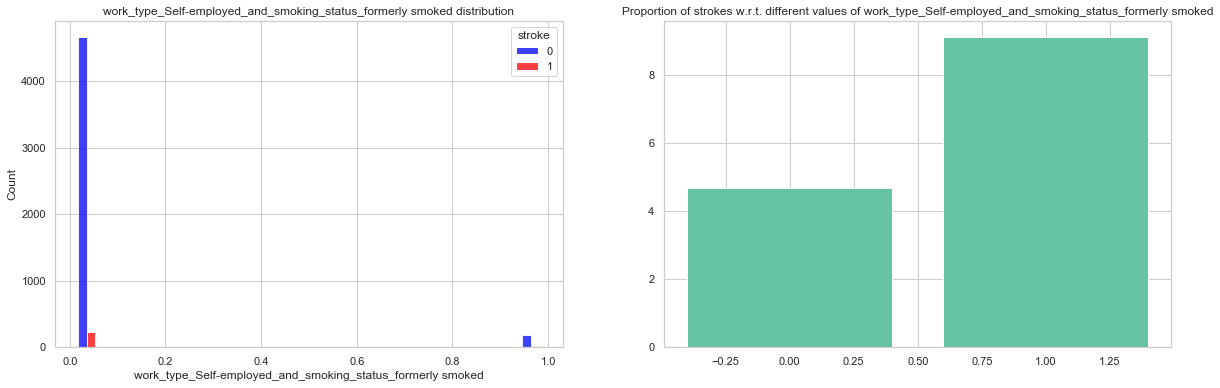

In [28]:
newPairs = [f"{feat1}_and_{feat2}" for feat1, feat2 in pairs]
histProbs(dataSet=dfData, features=newPairs, hue="stroke")   

We see that this "and" operation we have performed among boolean features, produces an increase in the probability of having a stroke wtih respect to the categorical features alone.

 ## 1.4 Correlations <a class="anchor" id="SubSection_1_4"></a>

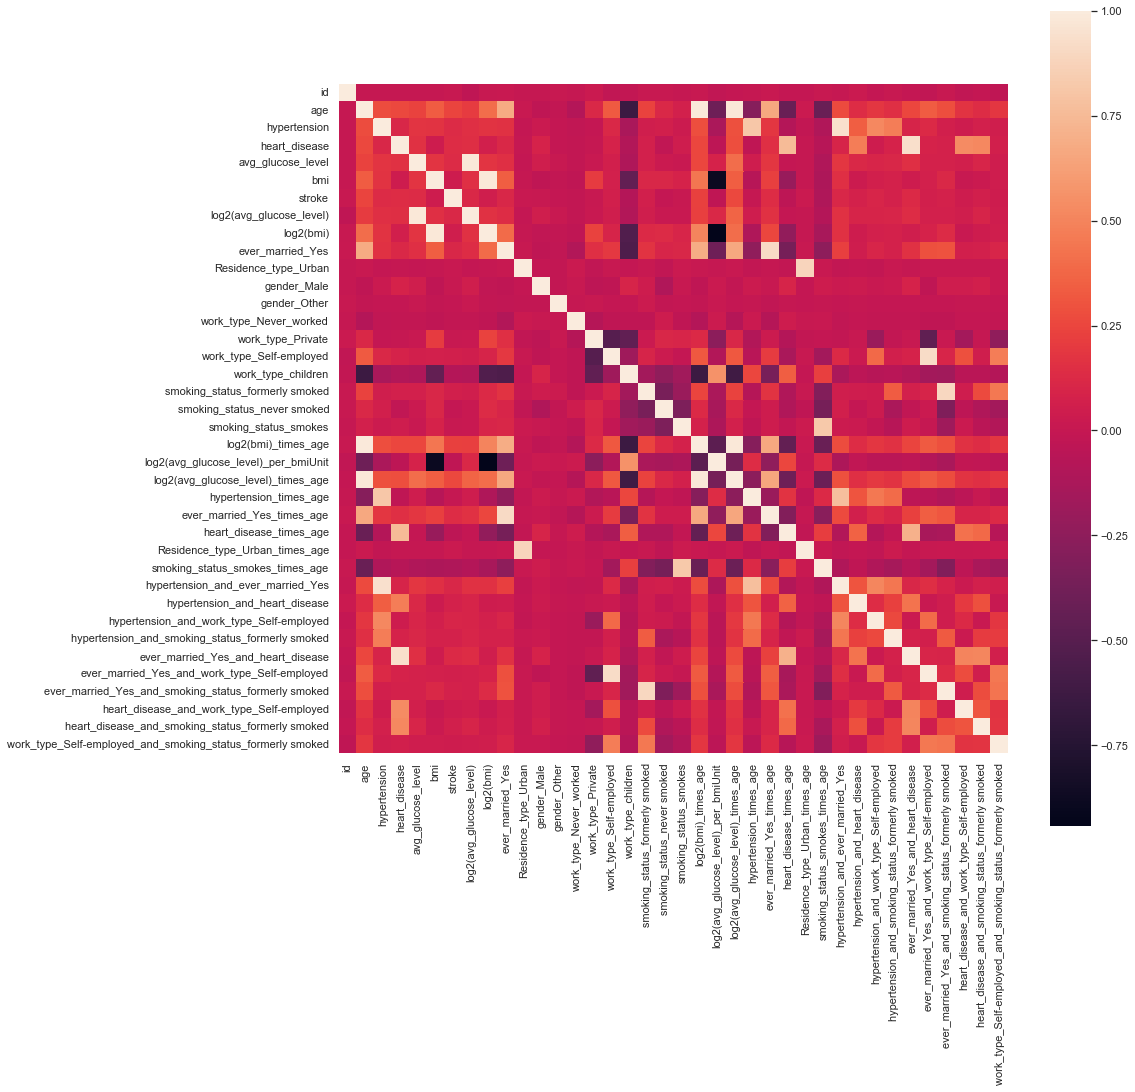

In [29]:
correlation_matrix = dfData.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix, vmax=1, square=True, ax=ax);

Let us filter the most correlated values

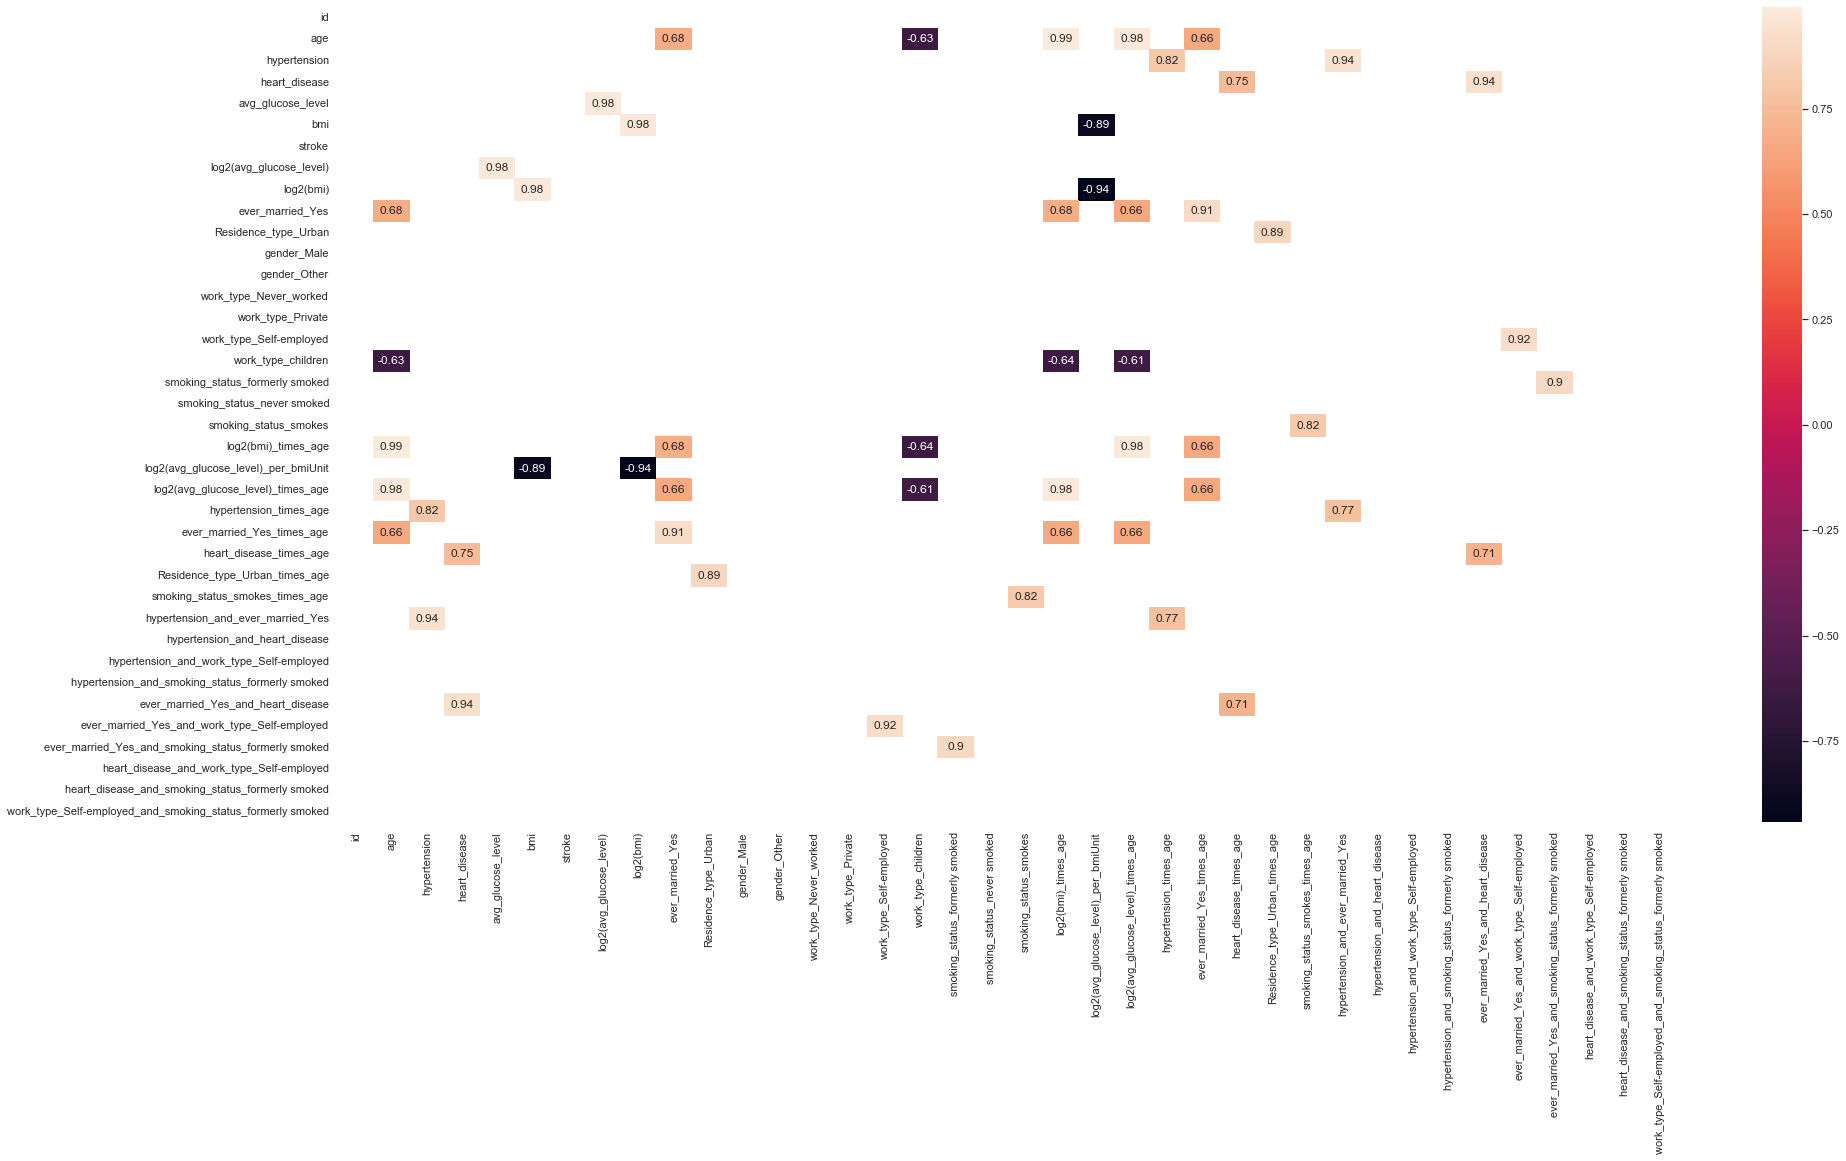

In [30]:

filteredDf = correlation_matrix[((correlation_matrix >= .6) | (correlation_matrix<= -.6)) & (correlation_matrix !=1.000)]
plt.figure(figsize=(30,15))
sns.heatmap(filteredDf, annot=True)
plt.show()


There seem to be no unexpected correlations. Most of the correlations are of the form:

corr(log2(avg_glucose_level)_times_age, age) = 0.98

which is to be expected. Although higly correlated, we will keep these variables for later analysis.

In [31]:
print(f"Number Continuous features: {len(nonCatFeat)} \n", nonCatFeat)
print(f"Number Categorical features: {len(CatFeat)} \n",CatFeat)

Number Continuous features: 13 
 ['avg_glucose_level', 'bmi', 'age', 'log2(avg_glucose_level)', 'log2(bmi)', 'log2(bmi)_times_age', 'log2(avg_glucose_level)_per_bmiUnit', 'log2(avg_glucose_level)_times_age', 'hypertension_times_age', 'ever_married_Yes_times_age', 'heart_disease_times_age', 'Residence_type_Urban_times_age', 'smoking_status_smokes_times_age']
Number Categorical features: 23 
 ['hypertension', 'heart_disease', 'ever_married_Yes', 'Residence_type_Urban', 'gender_Male', 'gender_Other', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'hypertension_and_ever_married_Yes', 'hypertension_and_heart_disease', 'hypertension_and_work_type_Self-employed', 'hypertension_and_smoking_status_formerly smoked', 'ever_married_Yes_and_heart_disease', 'ever_married_Yes_and_work_type_Self-employed', 'ever_married_Yes_and_smoking_status_formerly smoked', 'hea

 ## 1.5 Missing data<a class="anchor" id="SubSection_1_5"></a>
 
 Let us have a look to the amount of missing data per feature

In [32]:
#pandas series with the amount of elements missing per-feature, and sorted in descending order
total_missing = dfData.isnull().sum().sort_values(ascending=False)

#pandas series with the percentage of elements missing per-feature, and sorted in descending order
percent_missing = (round(dfData.isnull().sum()/dfData.count()*100,2)).sort_values(ascending=False)

#data frame containing both series above
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])
missing_data.head(20)

Total missing  \
log2(bmi)_times_age                                           201   
log2(avg_glucose_level)_per_bmiUnit                           201   
bmi                                                           201   
log2(bmi)                                                     201   
work_type_Self-employed_and_smoking_status_form...              0   
Residence_type_Urban                                            0   
work_type_Self-employed                                         0   
work_type_Private                                               0   
work_type_Never_worked                                          0   
gender_Other                                                    0   
gender_Male                                                     0   
ever_married_Yes                                                0   
smoking_status_formerly smoked                                  0   
log2(avg_glucose_level)                                         0   
stroke                                                          0   
avg_glucose_level                                               0   
heart_disease                                                   0   
hypertension                                                    0   
age                                                             0   
work_type_children                                              0   

                                                    Percent missing  
log2(bmi)_times_age                                            4.09  
log2(avg_glucose_level)_per_bmiUnit                            4.09  
bmi                                                            4.09  
log2(bmi)                                                      4.09  
work_type_Self-employed_and_smoking_status_form...             0.00  
Residence_type_Urban                                           0.00  
work_type_Self-employed                                        0.00  
work_type_Private                                              0.00  
work_type_Never_worked                                         0.00  
gender_Other                                                   0.00  
gender_Male                                                    0.00  
ever_married_Yes                                               0.00  
smoking_status_formerly smoked                                 0.00  
log2(avg_glucose_level)                                        0.00  
stroke                                                         0.00  
avg_glucose_level                                              0.00  
heart_disease                                                  0.00  
hypertension                                                   0.00  
age                                                            0.00  
work_type_children                                             0.00

We see that only 201 values are mising from the bmi feature, which is only 4,09% of the data missing. However, we recall that the imbalance ratio of stroke patienes also is around 4%. So, let's check whether that data is unvailable only for those stroke patients

In [33]:
dfData_strk = dfData[dfData["stroke"] == 1]

strk_missing = dfData_strk.isnull().sum().sort_values(ascending=False)

#pandas series with the percentage of elements missing per-feature, and sorted in descending order
strk_percent_missing = (round(dfData_strk.isnull().sum()/dfData_strk.count()*100,2)).sort_values(ascending=False)

#data frame containing both series above
strk_missing_data = pd.concat([strk_missing, strk_percent_missing], axis=1, keys=['Total missing', 'Percent missing'])
strk_missing_data.head(20)

Total missing  \
log2(bmi)_times_age                                            40   
log2(avg_glucose_level)_per_bmiUnit                            40   
bmi                                                            40   
log2(bmi)                                                      40   
work_type_Self-employed_and_smoking_status_form...              0   
Residence_type_Urban                                            0   
work_type_Self-employed                                         0   
work_type_Private                                               0   
work_type_Never_worked                                          0   
gender_Other                                                    0   
gender_Male                                                     0   
ever_married_Yes                                                0   
smoking_status_formerly smoked                                  0   
log2(avg_glucose_level)                                         0   
stroke                                                          0   
avg_glucose_level                                               0   
heart_disease                                                   0   
hypertension                                                    0   
age                                                             0   
work_type_children                                              0   

                                                    Percent missing  
log2(bmi)_times_age                                           19.14  
log2(avg_glucose_level)_per_bmiUnit                           19.14  
bmi                                                           19.14  
log2(bmi)                                                     19.14  
work_type_Self-employed_and_smoking_status_form...             0.00  
Residence_type_Urban                                           0.00  
work_type_Self-employed                                        0.00  
work_type_Private                                              0.00  
work_type_Never_worked                                         0.00  
gender_Other                                                   0.00  
gender_Male                                                    0.00  
ever_married_Yes                                               0.00  
smoking_status_formerly smoked                                 0.00  
log2(avg_glucose_level)                                        0.00  
stroke                                                         0.00  
avg_glucose_level                                              0.00  
heart_disease                                                  0.00  
hypertension                                                   0.00  
age                                                            0.00  
work_type_children                                             0.00

We see that it is not the case.  Among stroke patients only 19% of the data is missing. 

Since bmi is normally distributed, wqe shall use a simple mean imputer to fill in the missing values.

In [34]:
from sklearn.impute import SimpleImputer 

bmi_feats = ["log2(bmi)_times_age", "log2(avg_glucose_level)_per_bmiUnit", "bmi", "log2(bmi)"]

#Fitting imputer object and saving
imputer = SimpleImputer (strategy='mean') 
imputer.fit(dfData[bmi_feats]) 

#Transform
dfData[bmi_feats] = imputer.transform(dfData[bmi_feats])


In [35]:
print('Amount of missing values in the data set', dfData.isnull().sum().sum())

Amount of missing values in the data set 0


 ## 1.6 Scaling<a class="anchor" id="SubSection_1_6"></a>
 
 Althoug it is not necessary for tree based methods. We will standarize the data in case we use distance based methods. We will standarized with respect to the median and absolute median deviation, i.e. we shall use a RobustSacaler object, which is more resistant to outliers.
 

In [36]:
# #Fitting scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(with_centering=True, with_scaling=True, unit_variance=True)
scaler.fit(dfData[nonCatFeat])

dfData[nonCatFeat] = pd.DataFrame(scaler.transform(dfData[nonCatFeat]),
                                  index=dfData[nonCatFeat].index,
                                  columns=dfData[nonCatFeat].columns
                                 )

dfData

id       age  hypertension  heart_disease  avg_glucose_level  \
0      9046  0.824376             0              1           5.008743   
1     51676  0.599546             0              0           4.039250   
2     31112  1.311508             0              1           0.513853   
3     60182  0.149887             0              0           2.905001   
4      1665  1.274036             1              0           3.010811   
...     ...       ...           ...            ...                ...   
5105  18234  1.311508             1              0          -0.297841   
5106  44873  1.348980             0              0           1.219738   
5107  19723 -0.374717             0              0          -0.325666   
5108  37544  0.224830             0              0           2.724137   
5109  44679 -0.037472             0              0          -0.241824   

           bmi  stroke  log2(avg_glucose_level)  log2(bmi)  ever_married_Yes  \
0     1.229070       1                 3.153903   1.142403                 1   
1     0.073930       1                 2.728252   0.000000                 1   
2     0.614535       1                 0.491666   0.642720                 1   
3     0.899320       1                 2.153045   0.881678                 1   
4    -0.659501       1                 2.210936  -0.632420                 1   
...        ...     ...                      ...        ...               ...   
5105  0.073930       0                -0.320643   0.000000                 1   
5106  1.738685       0                 1.070088   1.516009                 1   
5107  0.329751       0                -0.352174   0.389362                 1   
5108 -0.419683       0                 2.051788  -0.360984                 1   
5109 -0.329751       0                -0.258024  -0.263548                 1   

      ...  hypertension_and_ever_married_Yes  hypertension_and_heart_disease  \
0     ...                                  0                               0   
1     ...                                  0                               0   
2     ...                                  0                               0   
3     ...                                  0                               0   
4     ...                                  1                               0   
...   ...                                ...                             ...   
5105  ...                                  1                               0   
5106  ...                                  0                               0   
5107  ...                                  0                               0   
5108  ...                                  0                               0   
5109  ...                                  0                               0   

      hypertension_and_work_type_Self-employed  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            1   
...                                        ...   
5105                                         0   
5106                                         0   
5107                                         0   
5108                                         0   
5109                                         0   

      hypertension_and_smoking_status_formerly smoked  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
...                                               ...   
5105                                                0   
5106                                                0   
5107                                                0   
5108                                   

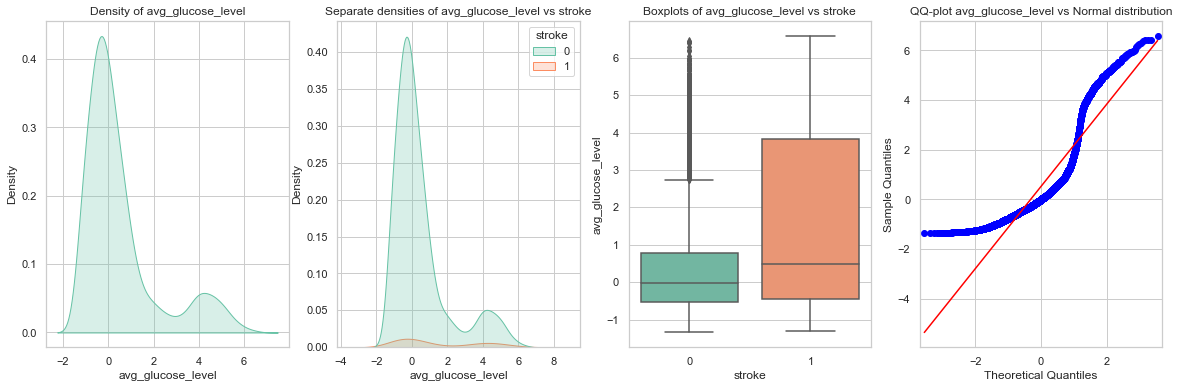

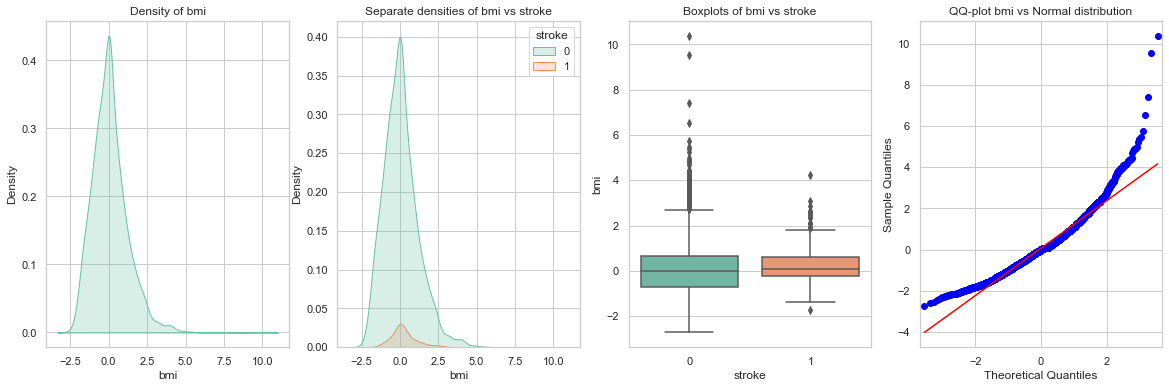

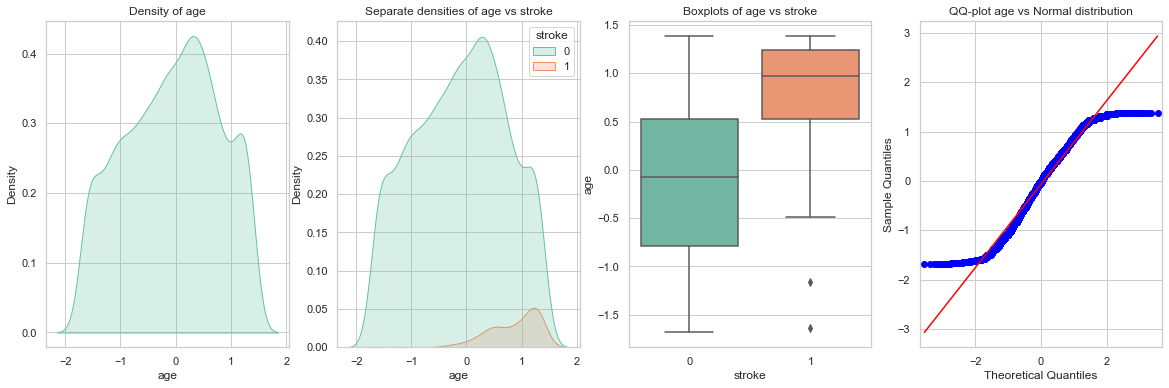

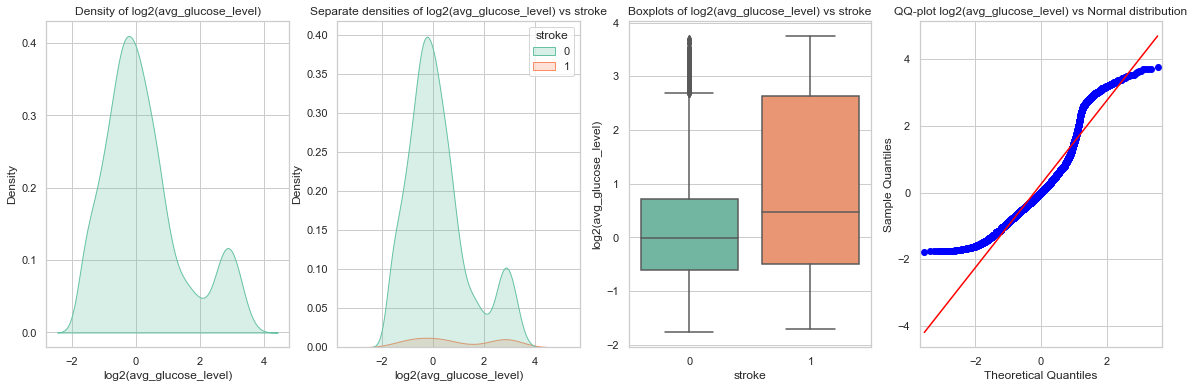

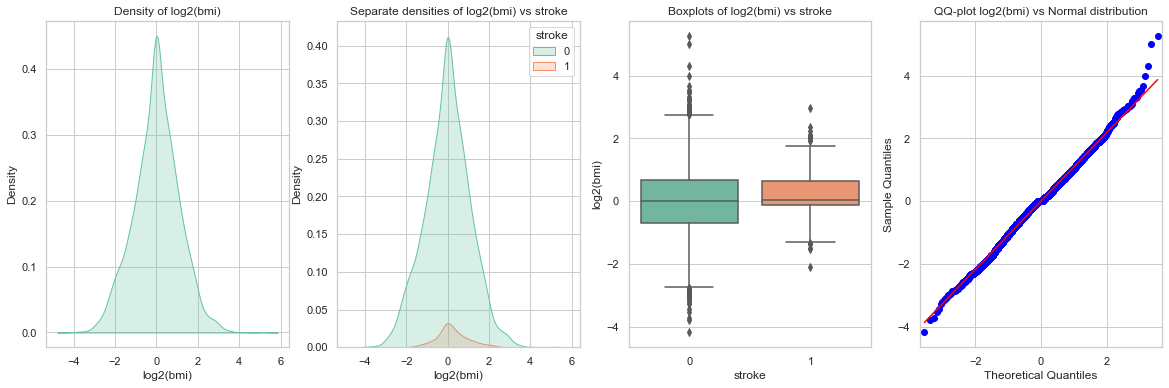

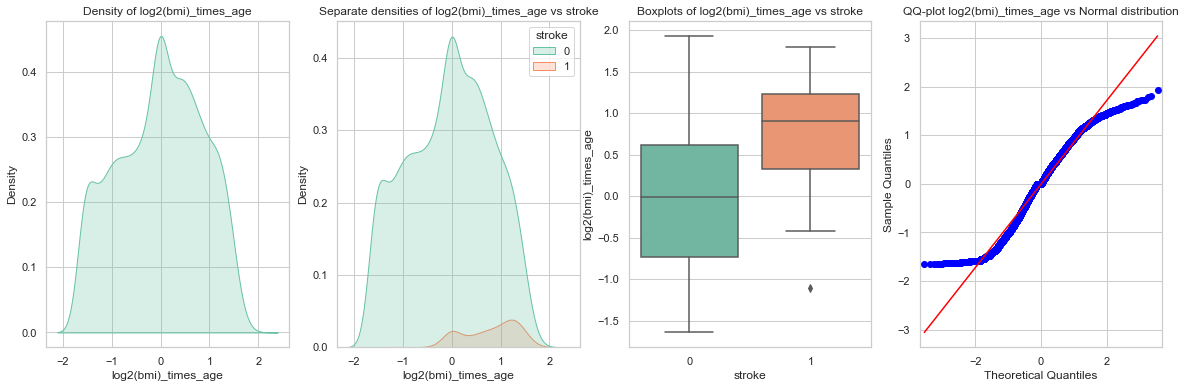

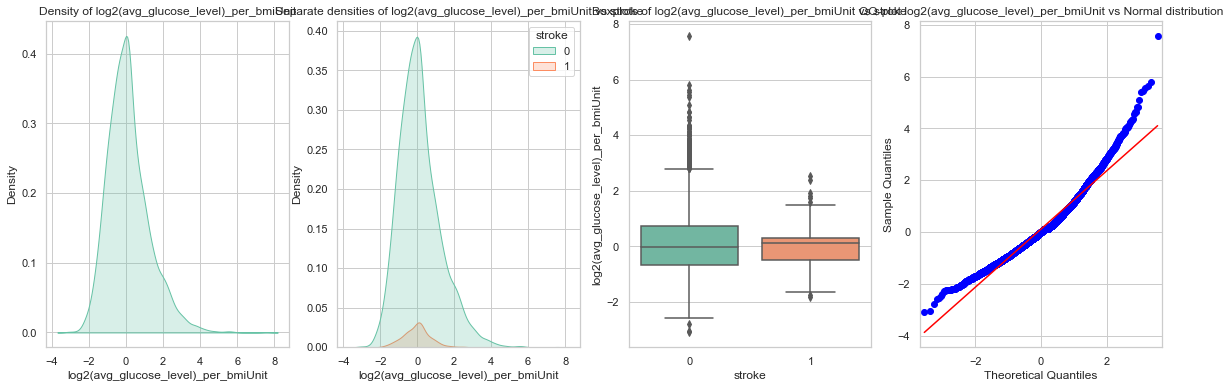

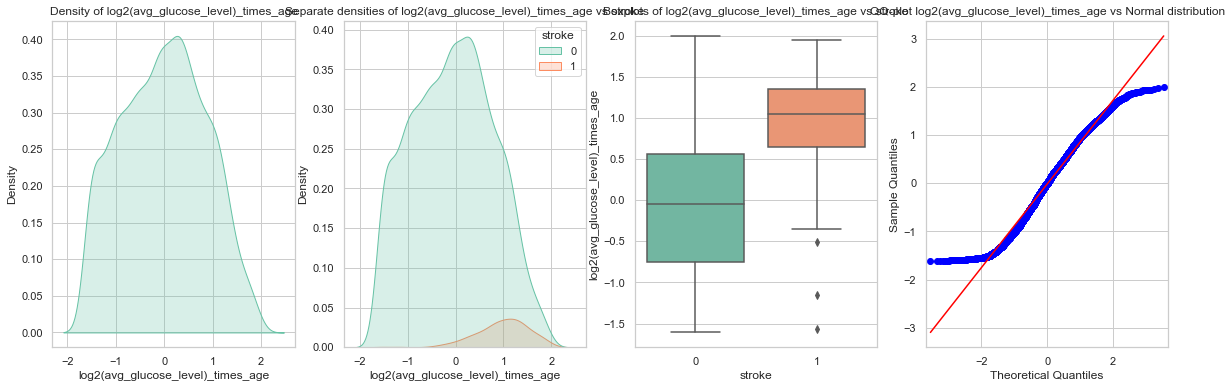

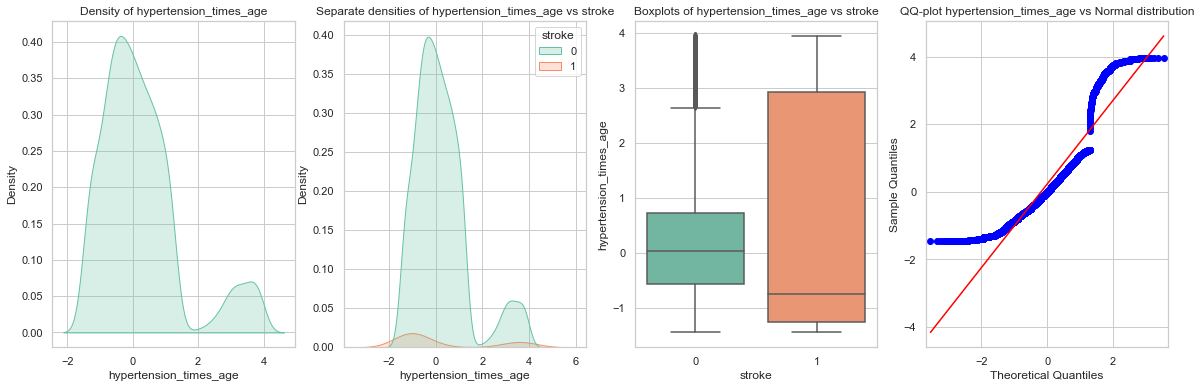

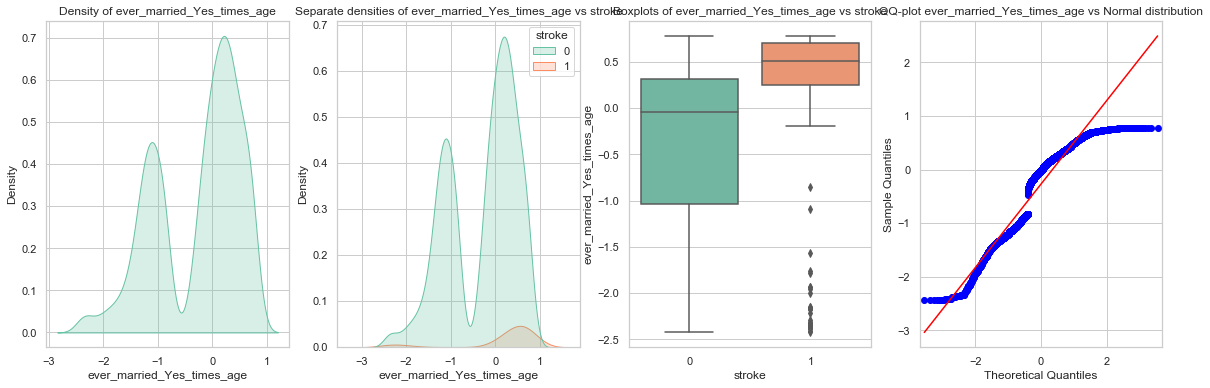

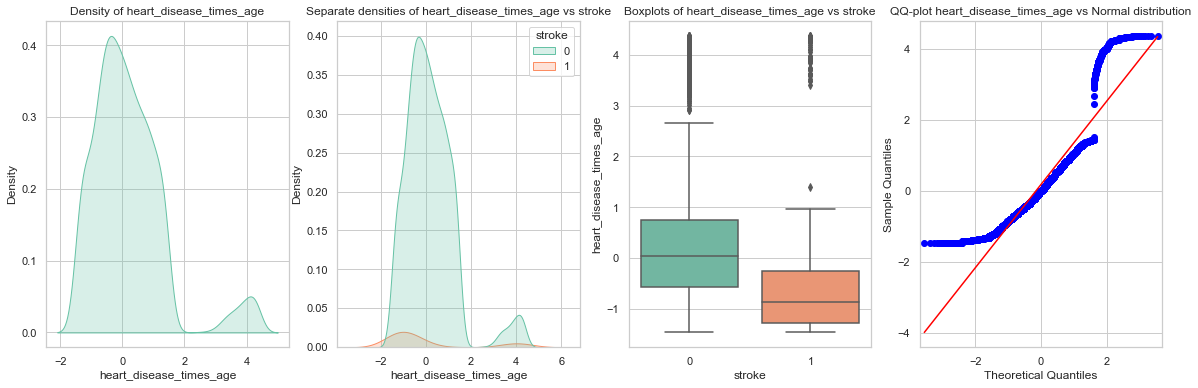

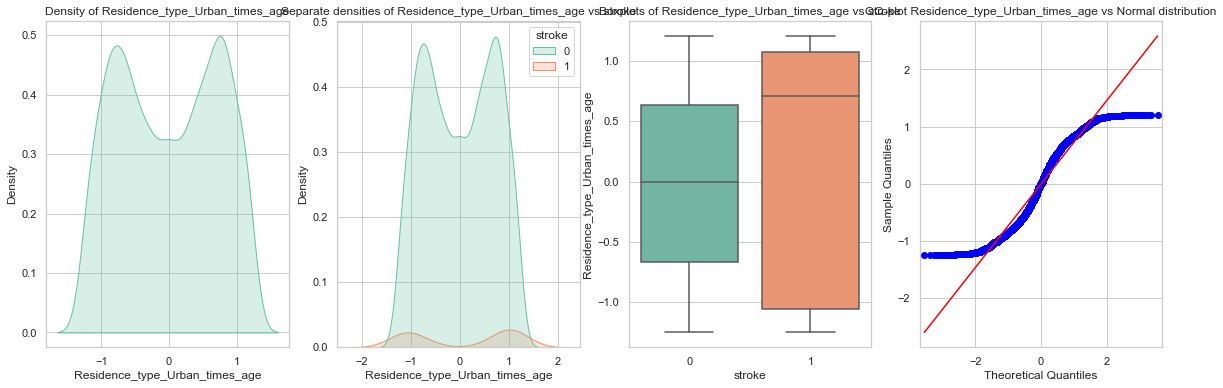

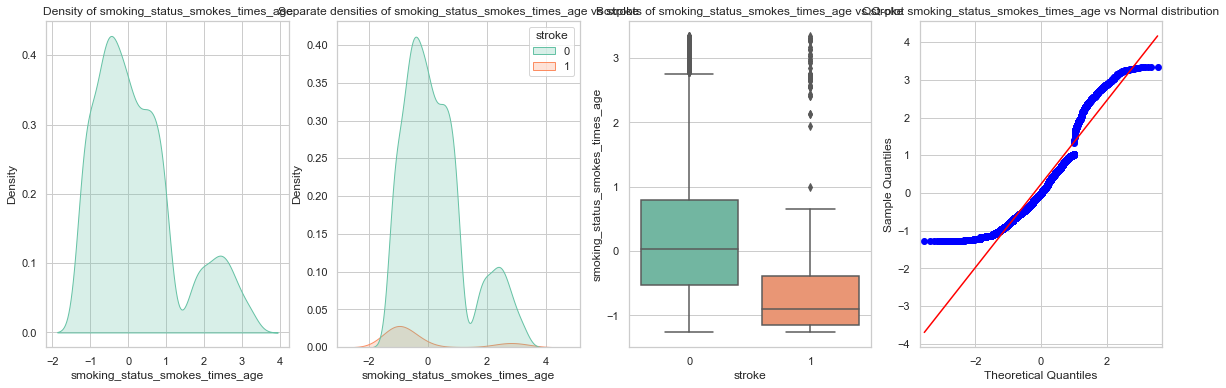

In [37]:
distPlot(dataSet=dfData, features=nonCatFeat, hue="stroke")

Let's check that the mean in each case is close to zero, and that the std is close to 1.

In [38]:
dfData[nonCatFeat].mean(axis=0)

avg_glucose_level                      5.221891e-01
bmi                                    7.392961e-02
age                                   -6.645169e-02
log2(avg_glucose_level)                2.487886e-01
log2(bmi)                             -2.890176e-15
log2(bmi)_times_age                   -7.121962e-03
log2(avg_glucose_level)_per_bmiUnit    1.135023e-01
log2(avg_glucose_level)_times_age     -1.893649e-02
hypertension_times_age                 2.272101e-01
ever_married_Yes_times_age            -2.719843e-01
heart_disease_times_age                1.824436e-01
Residence_type_Urban_times_age        -5.782162e-03
smoking_status_smokes_times_age        2.337395e-01
dtype: float64

In [39]:
dfData[nonCatFeat].std(axis=0)

avg_glucose_level                      1.657934
bmi                                    1.153830
age                                    0.847333
log2(avg_glucose_level)                1.252060
log2(bmi)                              1.092655
log2(bmi)_times_age                    0.859500
log2(avg_glucose_level)_per_bmiUnit    1.126536
log2(avg_glucose_level)_times_age      0.867423
hypertension_times_age                 1.236864
ever_married_Yes_times_age             0.779850
heart_disease_times_age                1.174168
Residence_type_Urban_times_age         0.731104
smoking_status_smokes_times_age        1.109070
dtype: float64

Finally, let's save the trasformed dataframe for further analysis. Let's also export the lists of cat and nonCat features in a json file for further use.

In [40]:
dfData.to_csv('transformedStrokeDataset.csv', index=False)

In [41]:

dct = {
    "nonCatFeat": nonCatFeat,
    "CatFeat": CatFeat
}

with open("featList.json", "w") as write_file:
    json.dump(dct, write_file)
